# Appendix C: measure the quality of imputation in terms of RSS gain

The purpose of this appendix is to better understand how the process for imputing values set out in appendices A and B affects the residual sum of squares---the sum of the squared differences between the actual, unobserved values and our imputed values.  If we artificially censor median_house_value at 300K, we can impute values for the censored records, using adjusted Gibbs sampler output, and then compare the imputed values against the actual values in the range 300K - 490K.  

Another purpose of this appendix is to investigate whether we can improve the Gibbs sampler output, as measured by RSS gain (defined in a moment), by changing the data used to construct the model that the Gibbs sampler relies on for its predictions.  In appendices A and B the algorithm models were constructed using the capped data; this has a significant effect on the power transformations used to tune the model.  These power transformations, in turn, affect the model's sigma (its residual standard error), the standard errors of the model's coefficients, and most importantly, the predictions themselves.  We are not required to construct the model with the capped data; we can instead substitute NAs for the capped values or even assign a different cap, such as our prediction for the mean of the actual, unobserved values.  Here I want to look into whether making any of these changes results in a set of imputed values which, on average, has a higher RSS gain than the original (and/or adjusted) output from the Gibbs sampler.


                                        * * * * *
                                        

As we saw in appendices A and B, we can improve upon the output from the Gibbs sampler by centering it around a predicted mean for the actual, unobserved values of the censored data.  This adjustment to the Gibbs output is only an enhancement if we have strong reasons for believing that our prediction for the mean is more plausible than the mean of the raw, unadjusted output from the Gibbs sampler.  There are times when this will be so.  This was the case for both the imputation in Appendix A and the imputation in Appendix B.

Another problem for the Gibbs output is that its distribution is likely to be substantially different from what we would expect.  When we are imputing values into the tail end of a variable's range, as is often the case for censored data, we expect the distribution counts to nearly always decrease as we move further to the right (i.e., as we move further into the tail of the distribution).  This is so when a modeling assumption---the model that the Gibbs sampler uses to generate the imputed values---is that the response variable, or some transformation of it, is normally distributed.  The problem is that the Gibbs sampler does not know that the range of imputation is in the tail of the variable's distribution.  And so it generates output that is randomly sampled from a truncated normal distribution, leading to a set of imputed values whose distribution shape is likely to be inconsistent with our "prior".  If, in order to correct for the mean, we have to shift the Gibbs output to the left, the shape of the imputed values will come a bit closer to that prior; however, if we have to shift the Gibbs output to the right, the shape of the imputed values becomes even less plausible.  As seen in appendices A and B, I have to shift the Gibbs output to the left.  I suspect that a shift to the left will nearly always be required, or else no shift.  A shift to the right is unlikely because we are imputing values (in these instances at least) that lie in the tail of a variable's range, and since the Gibbs sampler does not know this (i.e., that the record counts are dropping as we move to the right, often substantially), the mean will tend to be too far to the right.  Leftward shifts are good in that they improve upon the shape of the imputed values.  Yet, this improvement is likely to still leave us with a shape for the imputed values that does not fit with what we would expect to see.  At present, I know of no way to improve upon the distribution of the imputed values without substantially undermining the RSS gain we see with the original Gibbs output.

We can correct for one issue with the Gibbs output, but not exactly for the other.



                                       * * * * *



In what follows, I impute values for a subset of the median house values of the California housing dataset (the medians are of 1990 Census blocks).  I artificially censor the values at \\$300K and remove all median house values > \\$490K.  Any values at or above 500K are already imputed values rather than actual, observed values.

I work with artificially censored data in order to measure the accuracy of the imputed values.  The lower the residual sum of squared differences, the better the imputation IF the shape of the distribution of imputed values also resembles the shape of the distribution of actual values.  This qualification is needed because there might be circumstances in which the smallest RSS is obtained by setting all imputed values to the predicted mean.  For the type of imputation I am interested in here, this is not what we want.  I want the shape of the distribution of imputed values to match (to the extent that is possible) the shape of the distribution of actual, unobserved values.  In this artificial setup, we know exactly what the shape of that distribution is because we have the actual values for the range of imputation.  But also, when imputing for the data censored at 500K, we have a very good idea of what the general shape of the distribution is likely to be.

Why is the shape of the distribution of imputed values important?  We aim for the models we build with the imputed values to be as close to what they would be like if we had the actual data; we want this to be so in order to make good predictions with these models, including predictions in the range of imputation.  (It is possible, of course, that we might get better predictions below the cap and/or above the cap when our imputed values have a shape that we would never expect the actual values to have.  This inquiry, which I have pursued to a degree, is beyond the scope of this appendix.)  More importantly, perhaps, *we want the relationships between variables in the range of imputation to closely mimic what we would see if we had the actual data*.

As for the mean: the more the mean of the raw output from the Gibbs sampler differs from the actual mean, the greater the RSS is likely to be.  In Appendix B, the difference between the mean of the raw Gibbs sampler output and the predicted mean was \\$24K.  Assuming that the predicted mean is close to the real mean, the 24K difference is an error of around 4\%.  The 4\% difference may not seem like much, but the more we rely on the raw output predictions in the range of imputation, the more likely we are to be off, on average, by 24 thousand dollars (1990 dollars).



                                         * * * * *
                                         
  


# Section 1: Preliminaries

In [ ]:
# Load some of the required packages.

require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm)     # needed for Gibbs sampling used in imputation


In [2]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [3]:
# This dataset contains imputed values for housing_median_age.  
# The imputation was done in Appendix A.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [4]:
colnames(dat)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

In [5]:
# Remove all records with a median_house_value >= 500K since these
# are imputed values.  Here I use 490K as our upper limit.

dat_noCap <- dat[which(dat$median_house_value <= 490000),]
nrow(dat_noCap)


[1] 19574

In [6]:
# Keep only the columns we need.

required_cols <- c("median_house_value","median_income","latitude","long_transf",
                   "pop_per_hh","housing_median_age","HHdens_ln")

dat_noCap <- dat_noCap[, required_cols]
dim(dat_noCap)


[1] 19574     7

In [7]:
# Create a dataset with censored median_house_values.  Censor at
# 300K.

censored_rows <- rownames(dat_noCap[which(dat_noCap$median_house_value >= 300000),])
length(censored_rows)

dat_wCap <- dat_noCap
dat_wCap[censored_rows,]$median_house_value <- 300000

# We have 2,833 records which will need an imputed value.


[1] 2833

In [8]:
# How much of the data is censored?

round(length(censored_rows)/nrow(dat_wCap), 3)
# 14.5 percent


[1] 0.145

In [9]:
# Number of records in dat_wCap that are not capped:

nrow(dat_wCap) - length(censored_rows)
# 16,741


[1] 16741

In [ ]:
### COMMENTS:

# The 14.5% number is large.  It is 3X the number of records censored
# at 500K.

# I will use all 2833 records because the more predictions made, the
# better the measurement I have for the differences between using the
# raw Gibbs sampler output and the enhanced output.

# Because I have many fewer records to work with when constructing my
# prediction models (both for the mean of the actual, unobserved values
# >= 300K and for median_house_value), these models are likely to not be
# as good as what I used in Part01 and Appendix B of the CA housing repo.


## Get prediction for the mean of the actual, unobserved values

### Create 15K bins for median_house_value

In [10]:
# Rename dat_wCap to dat since this is the dataset we will be mostly
# working with.

dat <- dat_wCap


In [11]:
# Let 15K be the lowest median_house_value in our dataset.

summary(dat$median_house_value)

dat[which(dat$median_house_value < 15000), c("median_house_value")] <- 15000


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14999  116300  173400  181612  247575  300000 

In [12]:
cell_floors <- seq(from= 15000, to= 285000, by= 15000)
length(cell_floors)
names(cell_floors) <- paste(as.character(cell_floors/1000), "K", sep="")
print(cell_floors)


[1] 19

   15K    30K    45K    60K    75K    90K   105K   120K   135K   150K   165K 
 15000  30000  45000  60000  75000  90000 105000 120000 135000 150000 165000 
  180K   195K   210K   225K   240K   255K   270K   285K 
180000 195000 210000 225000 240000 255000 270000 285000 


In [13]:
# Function for obtaining the number of records in each 15K 
# interval.

get_rcd_counts <- function(med_houseVal, varRange, 
                           span=15000, startpt=15000) {  
    
    cell_floors <- seq(from=startpt, to=990000, by=span)
    names(cell_floors) <- paste(as.character(cell_floors/1000), "K", sep="")
    
    cell_floors_tmp <- cell_floors[(as.numeric(cell_floors) >= varRange[1]) &
                                   (as.numeric(cell_floors) <= varRange[2])]
    
    # This function returns record counts up to, but not including,
    # varRange[2].
    n <- length(cell_floors_tmp) - 1
    counts <- rep(NA, n)
    for(i in 1:n) {
        lower <- as.numeric(cell_floors_tmp[i])
        upper <- as.numeric(cell_floors_tmp[i + 1])
        counts[i] <- length(med_houseVal[((med_houseVal >= lower) &
                                          (med_houseVal < upper))])
    }
    names(counts) <- names(cell_floors_tmp)[1:n]
    return(counts) 
}


In [14]:
observed_counts <- get_rcd_counts(dat$median_house_value, c(15000, 300000))

print(observed_counts)


 15K  30K  45K  60K  75K  90K 105K 120K 135K 150K 165K 180K 195K 210K 225K 240K 
  14   78  587  965 1025 1295 1205 1088 1284 1538 1234 1239  842  931  959  747 
255K 270K 285K 
 656  615  439 


In [15]:
# Get the number of records not captured in observed_counts.

nrow(dat) - (sum(observed_counts) + 2833)


[1] 0

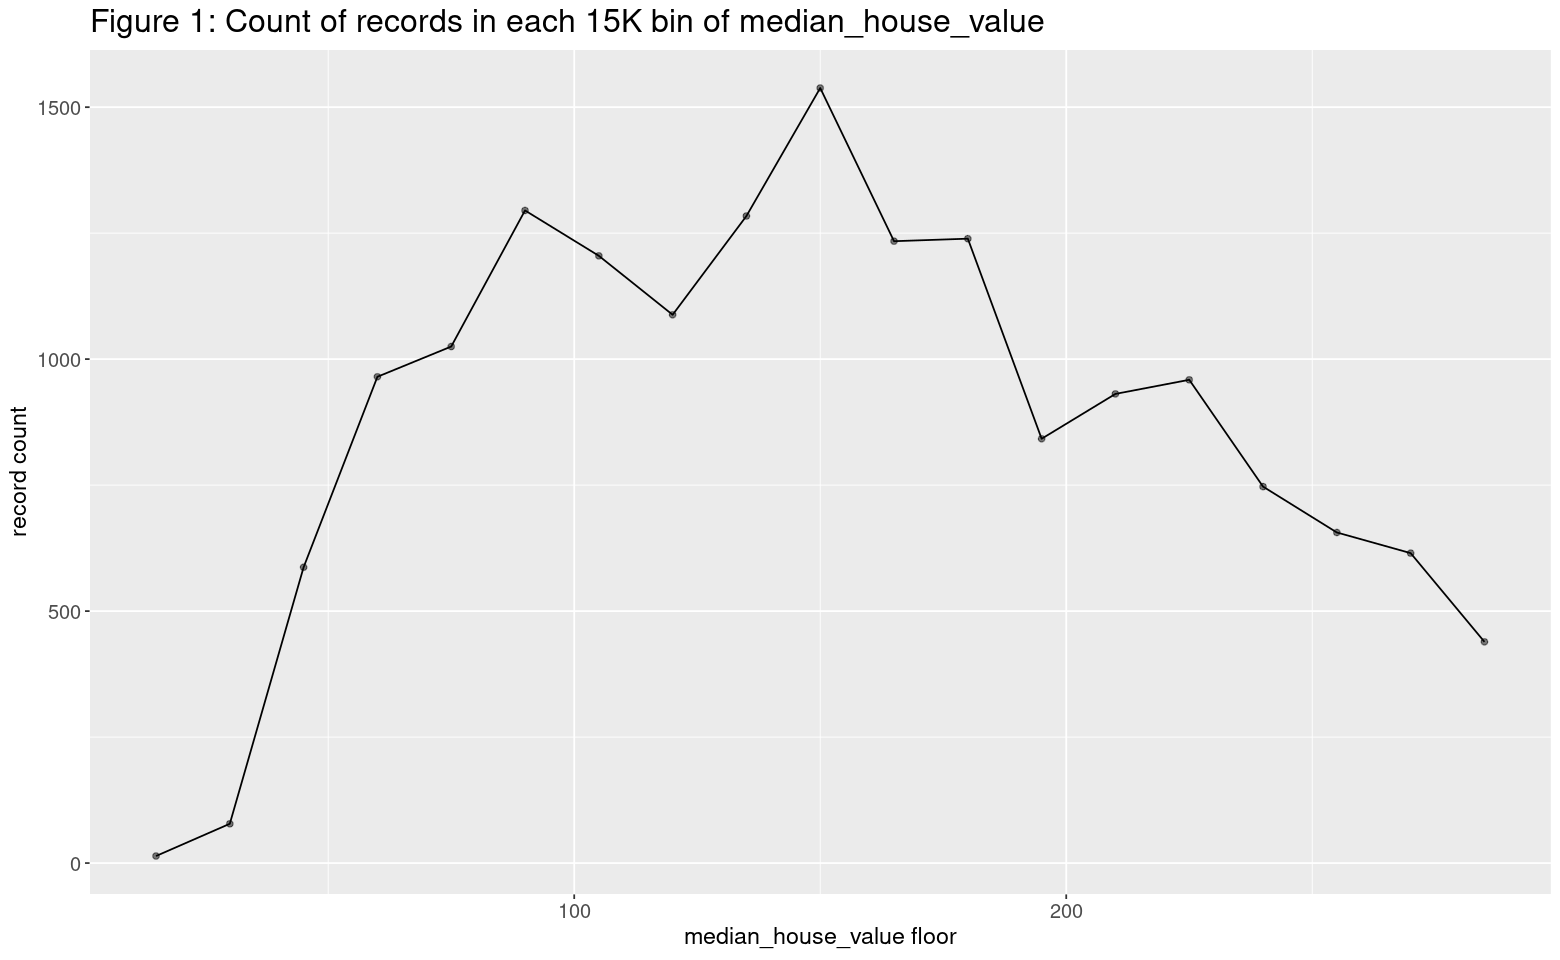

In [16]:
# Plot the counts.  This will give us a very general idea
# of what the distribution of counts might look like for the
# 2833 records which need an imputed value.  We are especially
# interested in the general shape of the distribution from
# around 150K onwards.

df_plot <- rep(NA, 2 * length(observed_counts))
dim(df_plot) <- c(length(observed_counts), 2)
df_plot <- as.data.frame(df_plot)
colnames(df_plot) <- c("cell", "count")

new_names <- str_replace_all(names(observed_counts), "[K]", "")
df_plot$cell <- as.numeric(new_names)
df_plot$count <- as.numeric(observed_counts)


options(repr.plot.width= 13, repr.plot.height= 8)

p <- ggplot(df_plot, aes(cell, count)) +
  geom_point(alpha= 0.5) + xlab("median_house_value floor") + 
  ylab("record count") +
  geom_line() +
  ggtitle("Figure 1: Count of records in each 15K bin of median_house_value") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENTS:

# As median_house_value increases beyond 285K, we expect the record
# count to trend downward, for there will be fewer districts
# with a high median house value.  In other words, beyond a certain
# point, record count will tend to be inversely proportional to 
# median_house_value.


## Hypothesized distribution

We have a general idea of what the general shape of the distribution of median house values will look like >= 300K.  It is important to make this "general idea" concrete.  Doing so provides us with a reference point against which we can judge the plausibility of the model predictions that follow (model predictions for the mean of the actual, unobserved values >= 300K). 

In Appendix B I used 10K-sized bins for modeling purposes.  Here I will stick with the 15K-sized bins since both 300K and 495K (see next cell) are divisible by 15.

In [17]:
# Create an example distribution for the expected range of
# imputation.  When imputing for the 500K censored values,
# I went out 1.65X 500K, to 825K.  So here I will do the same:
# 1.65 * 300K = 495K.  My model predictions have tended to 
# go out about 1.6X the upper limit, so here the limit of 
# 495K makes sense.  There is some cheating going on here,
# for I purposely chose a cut-off of 300K knowing that 
# 1.65*300 < 500.  I wanted to keep the point of censoring
# as large as possible in order to give me as much data as
# possible below the cap for modeling purposes.  But I kept
# the point of censoring small enough to allow for predictions
# to go out 1.65 times the cap.

bins <- seq(300000, 495000, by= 15000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
names(bins)
length(bins)
# 14


[1] "300K" "315K" "330K" "345K" "360K" "375K" "390K" "405K" "420K" "435K"
[11] "450K" "465K" "480K" "495K"

[1] 14

In [18]:
# We have 2833 records to distribute among 14 bins.  The only rule
# I use for assigning counts to the bins is that the counts nearly
# always decrease.  This assignment is not that easy because we know
# median house values go out beyond 500K, and likely even over 750K.
# This suggest that the downward trend not be too strong from 300K 
# to 495K.

bin_counts <- c(350, 330, 310, 270, 240, 223, 200, 175, 155, 145, 130, 
                125, 100, 80)
sum(bin_counts)
sum(bin_counts) == 2833


[1] 2833

[1] TRUE

In [19]:
# Construct a dataframe for plotting the example distribution.

all_names <- c(df_plot$cell[11:19], bin_names)
observed <- df_plot$count[11:19]

all <- c(observed, bin_counts)
n <- length(all)

dftmp <- rep(NA, 2 * n)
dim(dftmp) <- c(n, 2)
dftmp <- as.data.frame(dftmp)
colnames(dftmp) <- c("cell", "count")
dftmp$cell <- all_names
dftmp$count <- all

dftmp$hhval <- as.numeric(str_replace_all(dftmp$cell, "[K]", ""))

head(dftmp); tail(dftmp)


,cell,count,hhval
,<chr>,<dbl>,<dbl>
1,165,1234,165
2,180,1239,180
3,195,842,195
4,210,931,210
5,225,959,225
6,240,747,240


,cell,count,hhval
,<chr>,<dbl>,<dbl>
18,420K,155,420
19,435K,145,435
20,450K,130,450
21,465K,125,465
22,480K,100,480
23,495K,80,495


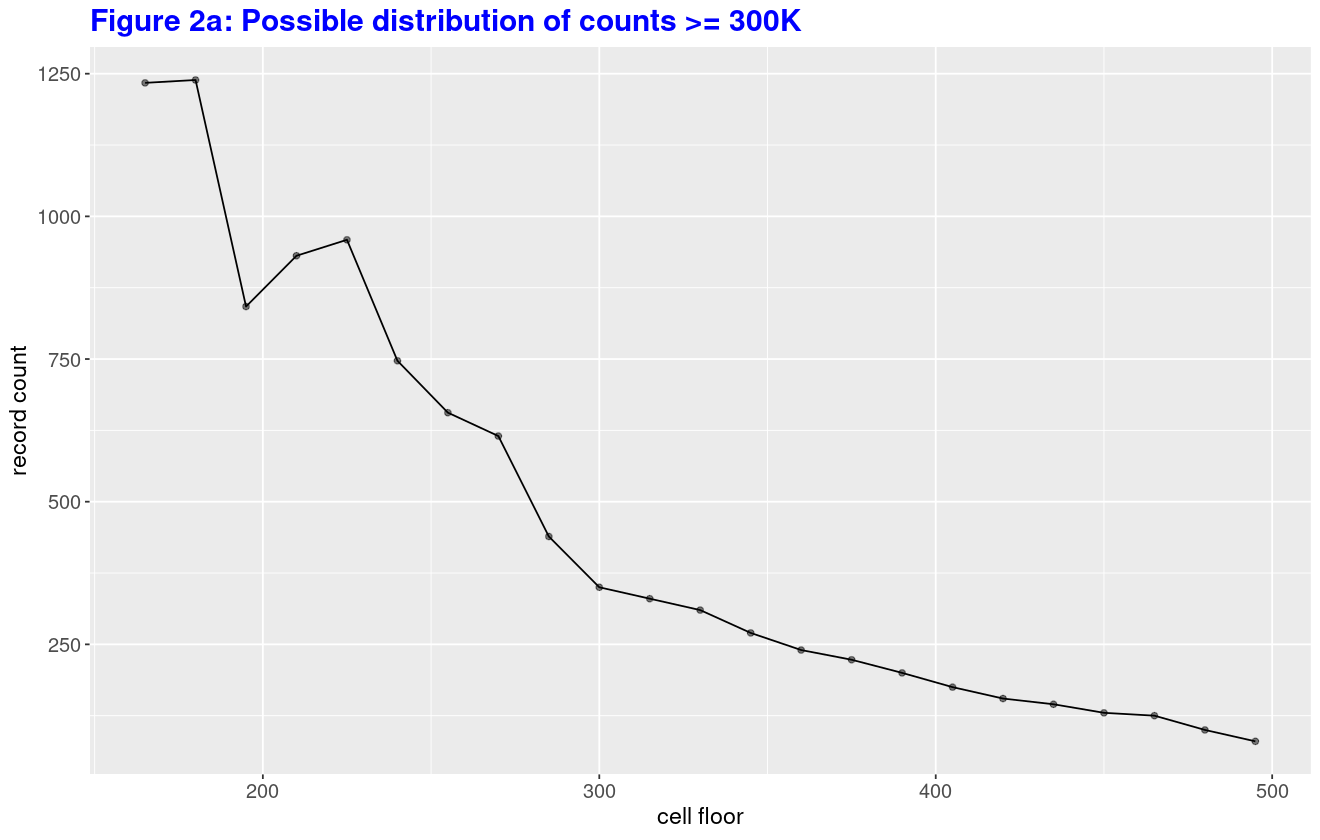

In [20]:
# Plot showing possible distribution of 2833 districts 
# with a median_house_value >= 300K.

options(repr.plot.width= 11, repr.plot.height= 7)

p <- ggplot(dftmp, aes(hhval, count)) +
  geom_point(alpha= 0.5) + xlab("cell floor") + ylab("record count") +
  geom_line() +
  ggtitle("Figure 2a: Possible distribution of counts >= 300K") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(plot.title= element_text(size= 18, face='bold',colour='blue'))
p


In [21]:
# Compute the mean of our example distribution.  This will
# be our first estimate of the mean of the actual, unobserved
# median house values >= 300K.

dftmp <- dftmp[which(dftmp$hhval >= 300),]

# newvals will be used in cells downstream.
newvals <- c()
for(i in 1:nrow(dftmp)) {

    n <- dftmp$count[i]
    lower <- dftmp$hhval[i]
    upper <- lower + 14.95
    
    seed <- set.seed(4321 + i)
    vals <- round(runif(n, lower, upper))
    newvals <- c(newvals, vals)
}

length(newvals)
# 2833
round(mean(newvals), 1)
# 380.1

# We need to impute values for 2833 records, and the mean
# of these imputed values should be in the neighborhood
# of 380K IF the distribution of hhvals >= 300K is similar
# to what we have for newvals.


[1] 2833

[1] 380.1

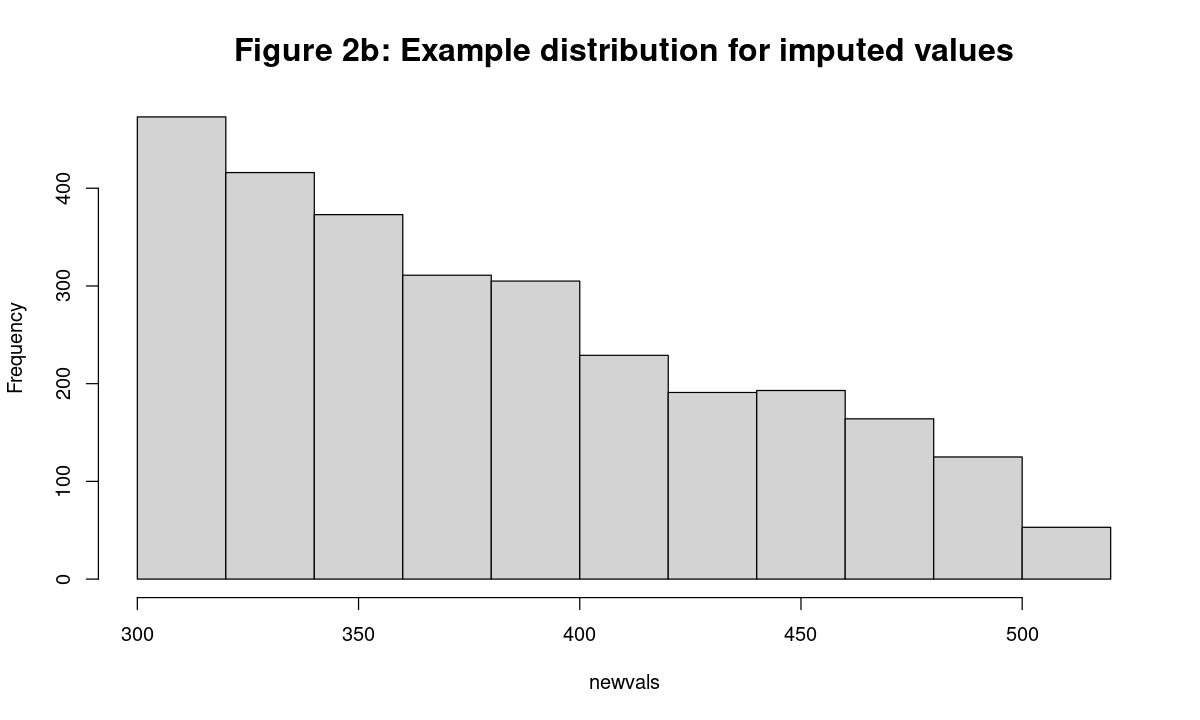

In [22]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(newvals, main="Figure 2b: Example distribution for imputed values",
     cex.main= 1.6)


In [23]:
# We have 2833 imputed values.

imputed_vals_tmp <- 1000*newvals


300K 315K 330K 345K 360K 375K 390K 405K 420K 435K 450K 465K 480K 495K 
 350  330  310  270  240  223  200  175  155  145  130  125  100   80 


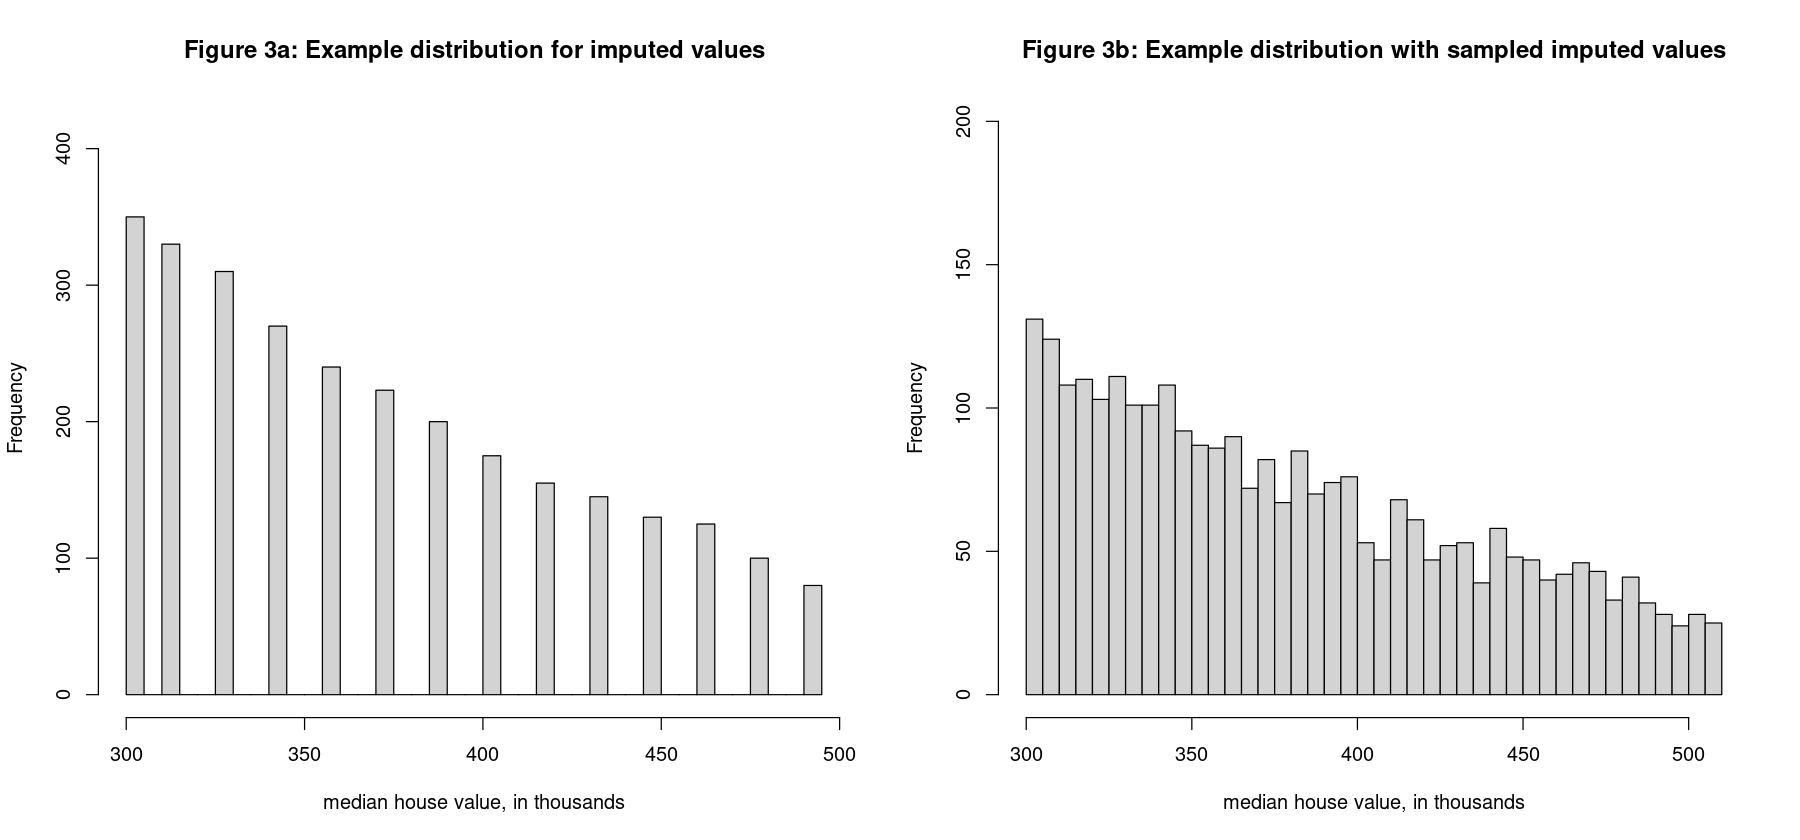

In [24]:
# The histogram below shows the counts for the example
# distribution; this is a close-up of Figure 2.

tbl <- bin_counts
names(tbl) <- bin_names
print(tbl)

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

hist(rep(dftmp$hhval, dftmp$count), breaks=30, xlab="median house value, in thousands",
     main="Figure 3a: Example distribution for imputed values", ylim=c(0, 420))

hist(newvals, breaks= 30, xlab="median house value, in thousands", ylim=c(0, 200),
     main="Figure 3b: Example distribution with sampled imputed values")


In [ ]:
### COMMENTS:

# Following Appendix A and Appendix B, I rely on Figures 2b and 3b
# for judging the plausibility of the predicted means using the
# models that follow.


## Compute shift-increment ratios for the mean using a 210K window

Use a rolling window of 210K.  This window captures nearly all of the current example distribution of the imputed  values when we start at the cap of 300K.  Compute data from 45K - 210K.  Although this takes us into the region of imputed values (we will use the example distribution of Figure 3b), most of the data for the last few 210K windows will still be observed rather than imputed.  (E.g., for the very last span, \[210K, 420K), imputed values make up 32.5\% of the data.)

See the discussion in Appendix B regarding the size of the window used for computing shift-increment ratios.  The larger the window, the larger the ratios become, which in turn means that our prediction for the mean of the actual, unobserved values will be biased---too high.  If the window is too small, we get a bias in the other direction.  So how do we know what the appropriate window size should be?  We have an appropriate window size if we get a model prediction that is reasonably close to the mean of our hypothesized distribution.  E.g., we expect our 95\% prediction interval to include the 380K prediction we already have.  If I use a 225K window, the lower bound for my 95\% prediction interval is 403K; this is 23K more than the 380K prediction we have from the hypothesized distribution.  Given that I am using 15K-sized bins, my next choice for window size is 210K.


In [25]:
# Here I start the sequence at 60K rather than 45K because 
# the point at 45K made finding a good model too difficult.
# (Here a good model is one with a high R-sqrd and which 
# passes both the Tukey test for linearity with respect to
# the fitted values and the ncvTest.)

bins <- seq(60000, 210000, by= 15000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
length(bins)


[1] 11

In [26]:
# See Figure 3b.
summary(newvals)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    300     332     370     380     422     510 

In [27]:
# Get count of newvals > 500K.

length(newvals[newvals > 500])

# Almost 1.9% of the 2833 records in newval have a 
# median house value > 500K.


[1] 53

In [28]:
# Combine the newly imputed values with the median house
# values in dat that are not censored.

all_hh_median_vals <- c(dat[which(dat$median_house_value < 300000), c("median_house_value")],
                        imputed_vals_tmp)
length(all_hh_median_vals)
summary(all_hh_median_vals)


[1] 19574

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  116300  173400  193204  247575  510000 

In [29]:
# Get the means for each bin, using a 210K window.  Note that 210K
# is divisible by 15K, the size of each median_house_value bin.
# (This is important because it means that we are never breaking
# a bin apart when calling get_rcd_counts in the loop below.)  Also,
# note that 300K + 210K = 510K, and 510K is the maximum value
# found in newvals.

mean_ratios <- rep(NA, length(bins))
means <- rep(NA, length(bins))
rcd_count <- rep(NA, length(bins))

span <- 210000
index <- 0
for(floor in bins) {
    
    index <- index + 1
    hhvals <- as.numeric(all_hh_median_vals[which((all_hh_median_vals >= floor) &
                                                  (all_hh_median_vals < (floor + span)))])
    counts <- as.numeric(get_rcd_counts(hhvals, c(floor, (floor+span))))
    rcd_count[index] <- sum(counts)
    
    # Compute mean.
    hhval_mean <- round(mean(hhvals), 5)
    mean_ratios[index] <- round(hhval_mean/floor, 3)
    means[index] <- hhval_mean

}

paste0("These are the 225K shift increments for the means: ")
names(mean_ratios) <- bin_names
print(mean_ratios)


[1] "These are the 225K shift increments for the means: "

  60K   75K   90K  105K  120K  135K  150K  165K  180K  195K  210K 
2.634 2.253 1.989 1.814 1.680 1.573 1.498 1.452 1.409 1.382 1.343 


In [30]:
# Construct dataframe for plotting, etc.

df_ratios <- rep(NA, 4*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 4)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("cell", "rcds","mean", "mean_ratio")
df_ratios$cell <- bins
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$mean <- means


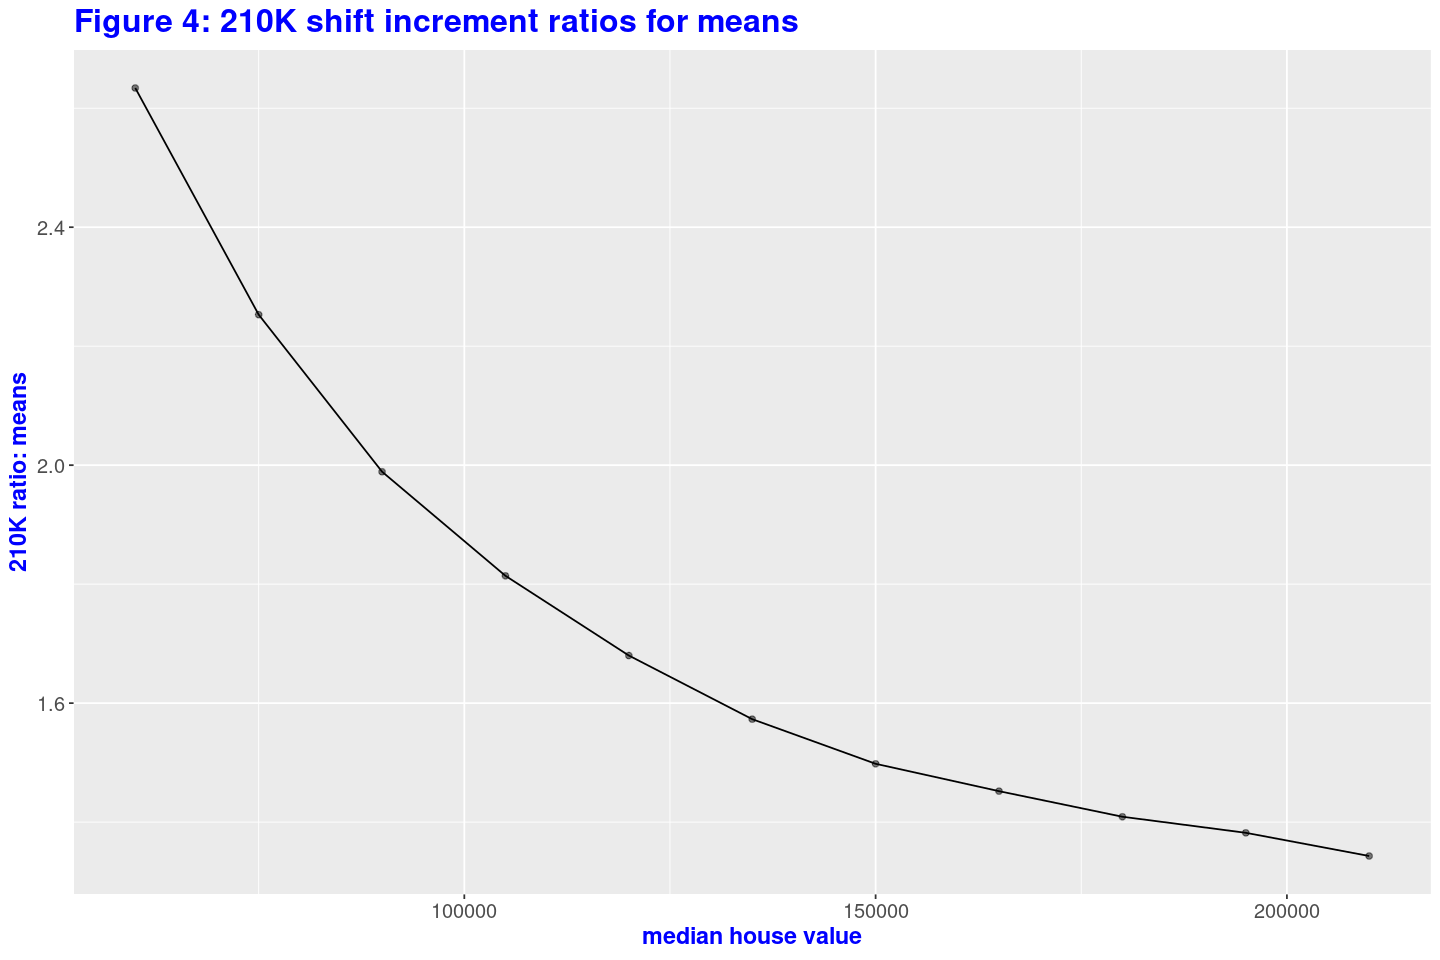

In [31]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(cell, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("210K ratio: means") +
  geom_line() +
  ggtitle("Figure 4: 210K shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16, face='bold',colour='blue'))
p


In [32]:
# Check the number of records at each of the 12 measurement points.

df_ratios$rcds


[1] 15008 14658 14072 13119 12241 11463 10457  9152  8141  7110  6440

In [33]:
# Model for predicting mean_ratio at 300K.

# A good model is crucial to getting a good prediction.

# Even though rcds is highly correlated with cell, we 
# get a much better q-q plot when we include it in the model.
# We also get a prediction closer to the 380K value.

g02 <- lm(I(mean_ratio^0.84) ~  I(cell^-0.547) + I(rcds^0.3) +
          I((rcds^0.3)^2), data= df_ratios)

ans <- summary(g02)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-1.63e-03 -5.91e-04 -5.68e-05  6.01e-04  1.46e-03 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)      7.73e-02   1.05e-01    0.74    0.486
I(cell^-0.547)   1.03e+03   4.23e+00  244.58  5.0e-15
I(rcds^0.3)      4.47e-02   1.34e-02    3.33    0.013
I((rcds^0.3)^2) -3.55e-03   4.48e-04   -7.93  9.7e-05

Residual standard error: 0.00113 on 7 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 2.52e+05 on 3 and 7 DF,  p-value: <2e-16


In [34]:
ncvTest(g02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.0082403, Df = 1, p = 0.928

In [35]:
residualPlots(g02, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(cell^-0.547)       0.15             0.89
I(rcds^0.3)          0.00             1.00
I((rcds^0.3)^2)     -0.59             0.58
Tukey test           0.21             0.84


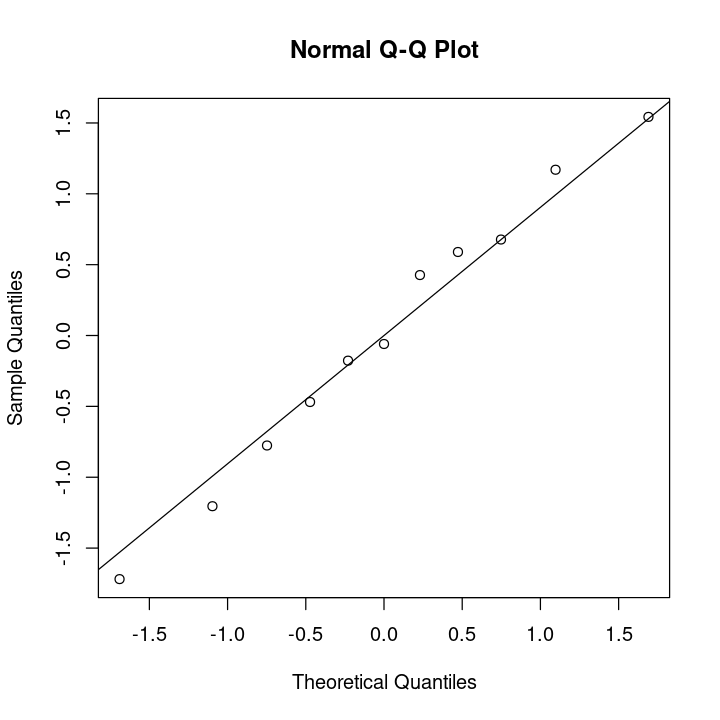

In [36]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g02, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [37]:
# Prediction for mean for the median house values
# in the interval [300K, 510K].

newdat <- df_ratios[1, ]
newdat[1, ] <- c(300000, 2833, rep(NA, 2))

ans <- predict.lm(g02, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.84); ans_transf
# 1.22716

# 1.22716 * 300K = 368.1K.


1 
1.2272

In [ ]:
### COMMENT:

# The 368K prediction for the mean is less than, but still
# in the neighborhood of the mean of newvals, which is at
# 380K.

# The 368K is 12K less than the 380K.  The 368K is 12K greater
# than 356K; 356K is the mean of the RAW output from the
# first run of the Gibbs sampler (see below).


In [38]:
newdat <- df_ratios[1, ]
newdat[1, ] <- c(300000, 2833, rep(NA, 2))

# Compute a 95% CI for this prediction.
pred_ans <- predict.lm(g02, newdata= newdat, interval="prediction",
                       level=0.95)
pred_ans_transf <- pred_ans^(1/0.84); pred_ans_transf


,fit,lwr,upr
1,1.2272,1.2019,1.2525


In [39]:
lwr <- round(pred_ans_transf[2] * 300)
upr <- round(pred_ans_transf[3] * 300)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, "K, ", upr ,"K]")
paste0(clause, print_ans)
# [361K, 376K]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [361K, 376K]"

In [40]:
# Compute an 80% CI for this prediction.  (I have to keep in 
# mind that not all of the values upon which the model is
# built are actual, observed values.  Some of the values
# upon which the g02 model relies are imputed.)

pred_ans <- predict.lm(g02, newdata= newdat, interval="prediction",
                       level=0.80)
pred_ans_transf <- pred_ans^(1/0.84)

lwr <- round(pred_ans_transf[2] * 300)
upr <- round(pred_ans_transf[3] * 300)

clause <- "80% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, "K, ", upr ,"K]")
paste0(clause, print_ans)
# [364K, 373K]


[1] "80% prediction interval for estimate of the mean of the actual, unobserved values: [364K, 373K]"

In [ ]:
### COMMENTS:

# Note that the estimate of 380K that we obtained from the example 
# distribution (Figures 3a and 3b above) is not captured by the
# 95% prediction interval.  But with the 210K window we are much
# closer than when we use a 225K window.  One way to perhaps avoid
# this is to use 10K bins; this would give us more options regarding
# window size.  In Appendix B I made use of 10K bins; I do not do 
# so here only because there is more work involved.


# Section 2: Impute values for the censored data

In [231]:
summary(dat$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  116300  173400  181612  247575  300000 

In [50]:
# The following model is what we will use to predict the
# median house values that we need.  Note that dat= dat_wCap;
# i.e., dat contains the censored data for which we need to
# impute values.  This makes tuning m01 difficult.  As soon
# as we change the median house values of the censored records,
# the model is likely to no longer satisfy the ncvTest and 
# the Tukey test.  Is this a defect in the Gibbs sampler approach
# to imputation?  I cannot get good predictions for vector z
# below unless the model I am relying on satisfies the basic
# requirements of linearity and constant variance.

# (We see in Sections 4-7 below that this is not a defect
# for the Gibbs sampler approach to imputing values.  This is
# because we are not trying to make individual point predictions
# but are instead only sampling from distributions which 
# capture the inferential uncertainty in the parameter estimates
# of our model.  Thus, the predictions from the Gibbs output are
# not at all like the g02 prediction just made in Section 1.)


m01 <- lm(I(median_house_value^0.728) ~ 
          
           I(median_income^1) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           I(pop_per_hh^1.5) +
           I(pop_per_hh^3.0) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
          data= dat)

m01.summary <- summary(m01)
m01.summary[[1]] <- ""; round(m01.summary$adj.r.squared, 3)


[1] 0.695

In [51]:
ncvTest(m01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.74989, Df = 1, p = 0.387

In [52]:
residualPlots(m01, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^1)            -16.26          < 2e-16
I(long_transf^-0.5)             2.31          0.02107
I(long_transf^-1)              11.47          < 2e-16
I(long_transf^-1.5)            11.86          < 2e-16
latitude                        1.65          0.09899
I(latitude^2)                   1.24          0.21497
I(latitude^3)                  32.98          < 2e-16
I(latitude^4)                  32.94          < 2e-16
I(pop_per_hh^1.5)              -0.33          0.74025
I(pop_per_hh^3)               -13.45          < 2e-16
I(housing_median_age^0.15)     -3.49          0.00048
HHdens_ln                       9.38          < 2e-16
Tukey test                     -0.10          0.91857


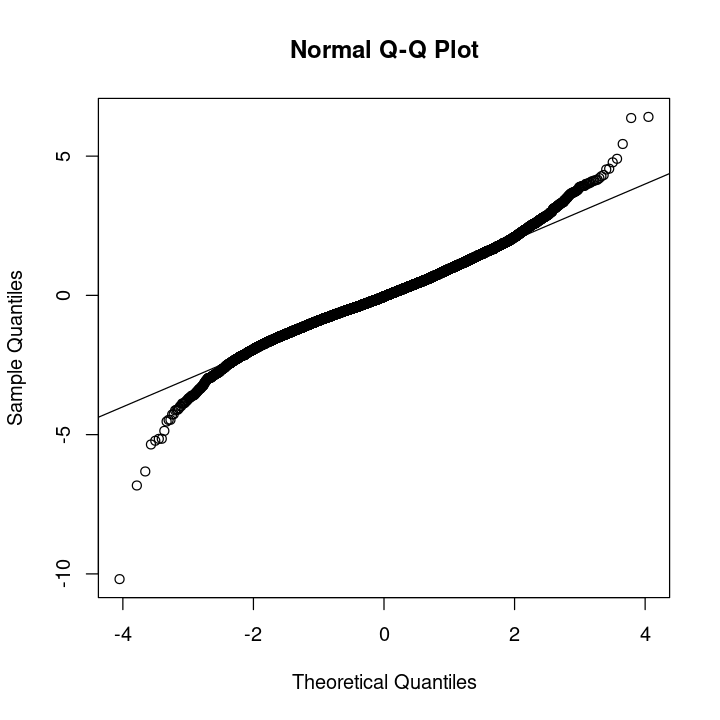

In [53]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(m01, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [54]:
# Get a sense of the uncertainty for the model's sigma.
# (sim is from the arm package.)

m01.sim <- sim(m01, n.sims=3000)


In [55]:
# Sigma is small because of the power transformation 
# on the response variable.

sigma.m01.sim <- sigma.hat(m01.sim)
str(sigma.m01.sim)


 num [1:3000] 1163 1166 1173 1171 1169 ...


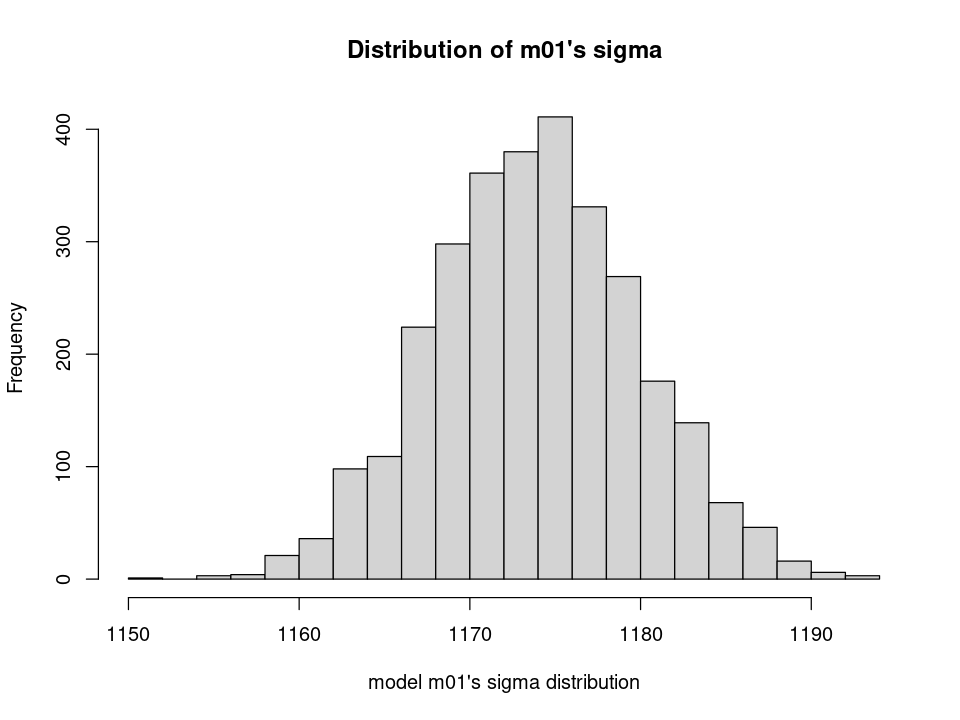

In [56]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(sigma.m01.sim, breaks=20, main="Distribution of m01's sigma",
     xlab="model m01's sigma distribution")


### Gibbs sampler for imputing censored median house values

In [41]:
# Because of the transformation on the response variable,
# we need to transform our limits.  Here I am setting the 
# upper limit to 504K. 

cap <- 300000
response_var_power <- 0.728
inv_pwr <- 1/response_var_power

C <- cap^response_var_power
C_upper <- (1.68*cap)^response_var_power

censored <- (dat$median_house_value)^response_var_power >= C

# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$median_house_value)^response_var_power)
z[censored] <- runif(n.censored, C, C_upper)


In [42]:
length(censored)
n.censored


[1] 19574

[1] 2833

In [43]:
summary(z[censored])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9717   10822   11955   11953   13089   14168 

In [44]:
# Identify the rows that are censored.

rows_censored <- rownames(dat)[censored]
c(head(rows_censored), tail(rows_censored))


[1] "1"     "2"     "3"     "4"     "5"     "104"   "20502" "20503" "20504"
[10] "20505" "20528" "20534"

In [45]:
# Function to draw from a constrained normal distribution.

rnorm.trunc03 <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need each mu to be >= C.  Otherwise the return 
    # value will be Inf.
    cap <- 300000
    mu02 <- ifelse(mu <= C, (cap + 100)^response_var_power, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [62]:
# Create matrix X for the terms in our model.

X <- dat

X$median_income <- X$median_income

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$long_1 <- (X$long_transf)^-0.5
X$long_2 <- (X$long_transf)^-1
X$long_3 <- (X$long_transf)^-1.5

X$pphh1 <-  (X$pop_per_hh)^1.5
X$pphh2 <- (X$pop_per_hh)^3.0

X$housing_median_age <- (X$housing_median_age)^0.15

X$HHdens_by_long <- X$HHdens_ln * X$long_transf
X$HHdens_by_income <- X$HHdens_ln * X$median_income
X$HHdens_3way <- X$HHdens_ln * X$median_income * X$housing_median_age



X <- X[, c("median_income","long_1","long_2","long_3","latitude","lat2",
           "lat3","lat4","pphh1","pphh2", "housing_median_age",
           "HHdens_ln", "HHdens_by_long","HHdens_by_income",
           "HHdens_3way")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 19574    16

[1] "intercept"          "median_income"      "long_1"            
 [4] "long_2"             "long_3"             "latitude"          
 [7] "lat2"               "lat3"               "lat4"              
[10] "pphh1"              "pphh2"              "housing_median_age"
[13] "HHdens_ln"          "HHdens_by_long"     "HHdens_by_income"  
[16] "HHdens_3way"

In [63]:
# See p.406 (Section 18.5) of Gelman and Hill's book,
# "Data Analysis Using Regression and Multilevel/Hierarchical
# Models".

# Fit a regression using the crude starting values of z.

m01_tst <- lm(z ~ 
             
           I(median_income^1) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           I(pop_per_hh^1.5) +
           I(pop_per_hh^3.0) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
              
           data= dat)    

# Obtain a sample draw of the model coefficients and of
# parameter sigma.
sim.1 <- sim(m01_tst, n.sims=1)


In [64]:
beta <- coef(sim.1)
dim(beta)
colnames(beta)


[1]  1 16

[1] "(Intercept)"                               
 [2] "I(median_income^1)"                        
 [3] "I(long_transf^-0.5)"                       
 [4] "I(long_transf^-1)"                         
 [5] "I(long_transf^-1.5)"                       
 [6] "latitude"                                  
 [7] "I(latitude^2)"                             
 [8] "I(latitude^3)"                             
 [9] "I(latitude^4)"                             
[10] "I(pop_per_hh^1.5)"                         
[11] "I(pop_per_hh^3)"                           
[12] "I(housing_median_age^0.15)"                
[13] "HHdens_ln"                                 
[14] "HHdens_ln:long_transf"                     
[15] "HHdens_ln:median_income"                   
[16] "HHdens_ln:median_income:housing_median_age"

In [55]:
# Here are means for 6 different normal distributions.

means <- as.matrix(X) %*% t(beta)
length(means)
round(head(as.vector(means)^inv_pwr))


[1] 19574

[1] 349776 362786 272073 231903 195045 200898

In [56]:
# All values should be between 300K and 504K
z.old <- z[censored]
round(head(z.old)^inv_pwr)


[1] 498242 365510 413074 459654 433261 491140

In [57]:
# All values should be between 300K and 504K.
sigma <- sigma.hat(sim.1)
round(sigma, 4)

z.new <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
round(head(as.vector(z.new)^inv_pwr))


[1] 1628

[1] 404695 390066 306058 313941 363334 362782

In [58]:
summary(z.new^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300058  322938  350509  359703  387990  503703 

In [178]:
# For the Gibbs sampler, the above is now put into
# a loop.  We first test with 100 iterations.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

# We have 16 terms in the model (including the intercept) as
# well as parameter sigma.  Thus, besides storing the imputed
# values, we need to have 17 additional slots.
sims <- array(NA, c(n.iter, n.chains, 17 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        m01.1 <- lm(z ~ 
                    
           I(median_income^1) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           I(pop_per_hh^1.5) +
           I(pop_per_hh^3.0) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)   
        
        sim.1 <- sim(m01.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        stopifnot(sum(z[censored] < Inf) == n.censored)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.7 minutes.


Time difference of 4.7 mins

In [ ]:
# Check for convergence.

# sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
# print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [180]:
save(sims, file="/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims_raw_hhvals_300Kcap.RData")


In [32]:
load("/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims_raw_hhvals_300Kcap.RData")


In [33]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 2850

In [34]:
sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [35]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 11166 11293 10798 10788 10790 10769

[1] 928.13 987.20 814.69 813.14 806.65 809.16

In [36]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10747   10789   10799   10842   10811   13665 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    462     806     815     826     824    1096 

In [37]:
summary(round(z_means^inv_pwr))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 344741  346577  347007  348934  347541  479502 

In [38]:
# Average estimate of the sd.

(sd_estimate <- round((10842 + 826)^inv_pwr) - round(10842^inv_pwr))
# $37,027


[1] 37027

In [39]:
# Here is a fuller summary for the stddevs.

ans <- round((z_means + z_sds)^inv_pwr) - round(z_means^inv_pwr)
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  22395   36075   36458   37047   36882   50983 

In [ ]:
### COMMENTS:

# Based on the prediction from g02, we expect the mean 
# to be about 368K if the upper limit is around 504K.  
# The mean is currently around 356K (see next summary).

# The 95% prediction interval for the 368K prediction
# is [361K, 376K].  Notice that the 356K number is not 
# in this interval.  However, the 95% interval is
# partly dependent on the example distribution of
# Figures 2b and 3b, and we do not know the degree to 
# which the shape of the example distribution resembles
# the shape of the actual distribution of unobserved 
# median house values in the range of imputation.  

# The 368K prediction is halfway between 380K and 356K.


In [40]:
# Get some predictions, using rnorm.trunc03.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)

# Notice that the mean is at 356K.  We do not expect the mean 
# to be this low because model g02 is a fairly good model 
# and it predicts a mean much closer to 368K.  Also, the 
# example distribution of Figure 3b has a mean at 380K.  So
# we have 2 good reasons for thinking that 356K is too low.
# Does the Gibbs sampler generate a mean this low because
# dat contains the censored data?


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300020  331200  352240  355799  375694  499944 

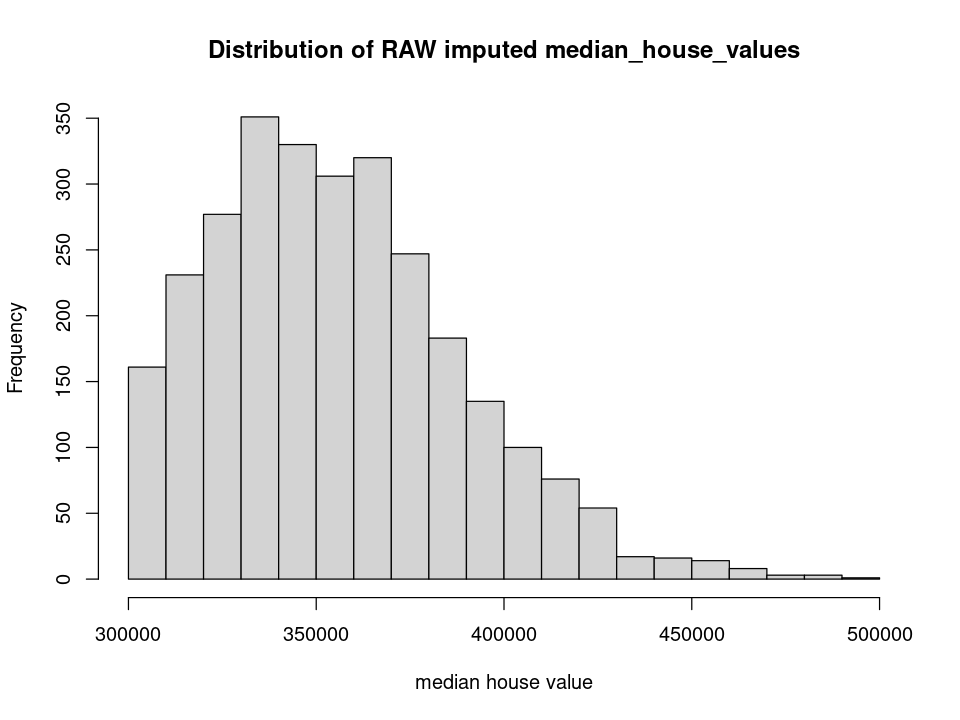

In [55]:
# The shape of the distribution below is not what we 
# hypothesized.  The Gibbs sampler is very constrained
# in the type of shape it can generate; the prediction
# model that it employs assumes that the response variable
# is normally distributed.  We do not see a normal dist-
# ribution below because the Gibbs output is constrained
# by rnorm.trunc03.

options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, main="Distribution of RAW imputed median_house_values",
     xlab="median house value")


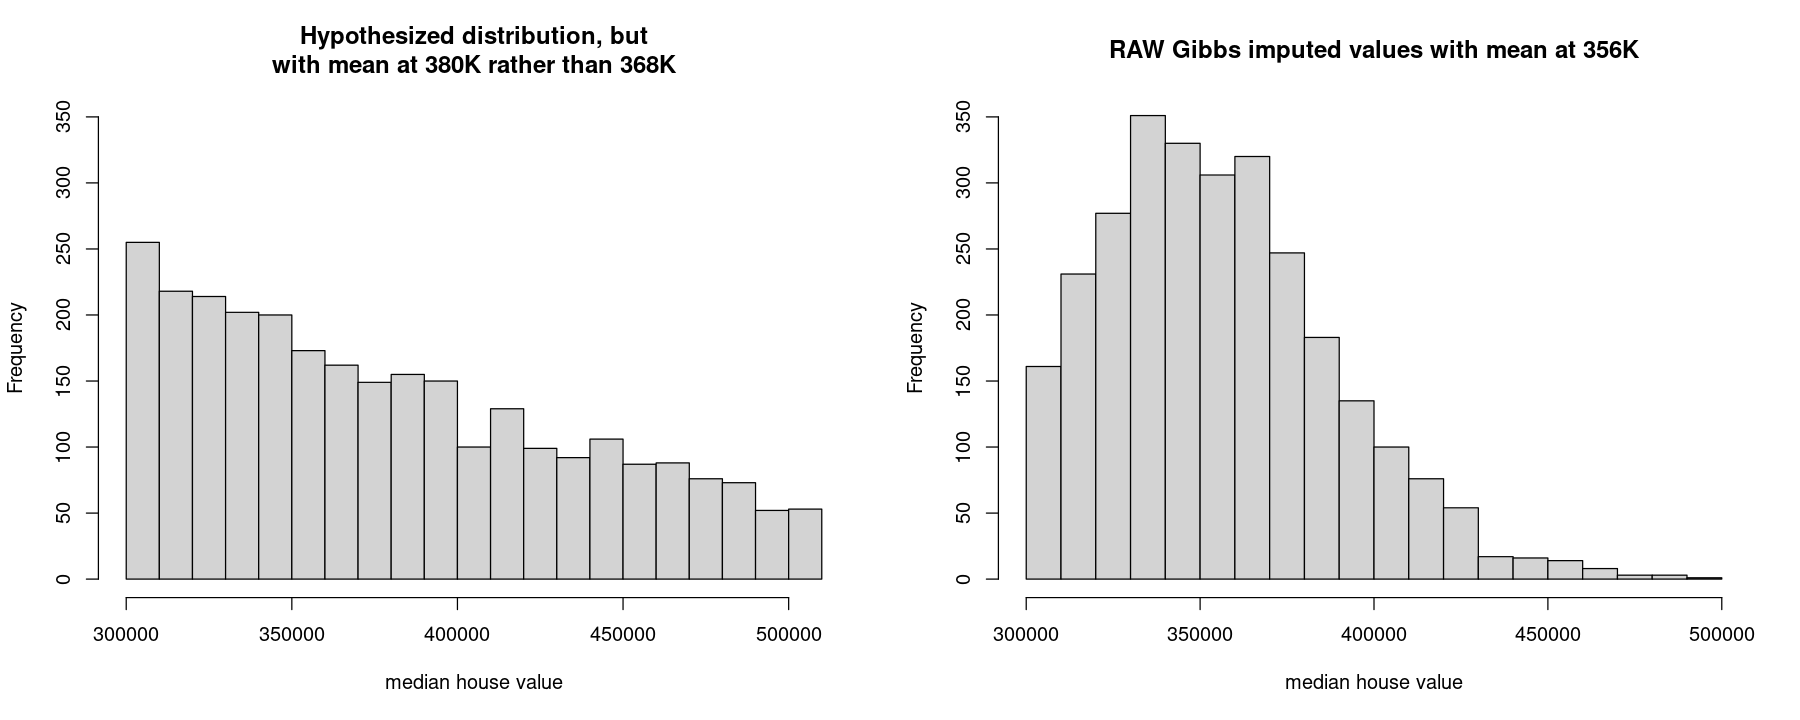

In [42]:
# Compare hypothesized distribution to the above distribution.

options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# Left panel.
hist(imputed_vals_tmp, breaks=20, main="Hypothesized distribution, but
with mean at 380K rather than 368K",
     ylim=c(0, 350), xlab="median house value")

# Right panel.
hist(z_preds, breaks=20, main="RAW Gibbs imputed values with mean at 356K",
     ylim=c(0, 350), xlab="median house value")


In [43]:
# Assign the raw, imputed values to the censored records of a 
# copy of dat.  Then save out the file so that we can later 
# use it to compare with the adjusted (enhanced) imputed
# values.

newdat_raw <- dat
newdat_raw$median_house_value[censored] <- z_preds
summary(newdat_raw$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  116300  173400  189688  247575  499944 

In [76]:
# Save to disk.

write.csv(newdat_raw,
          file="/home/greg/Documents/stat/sandbox/. . ./datasets/housing/data_with_raw_imputed_values_for_ppt.csv",
          row.names=TRUE)


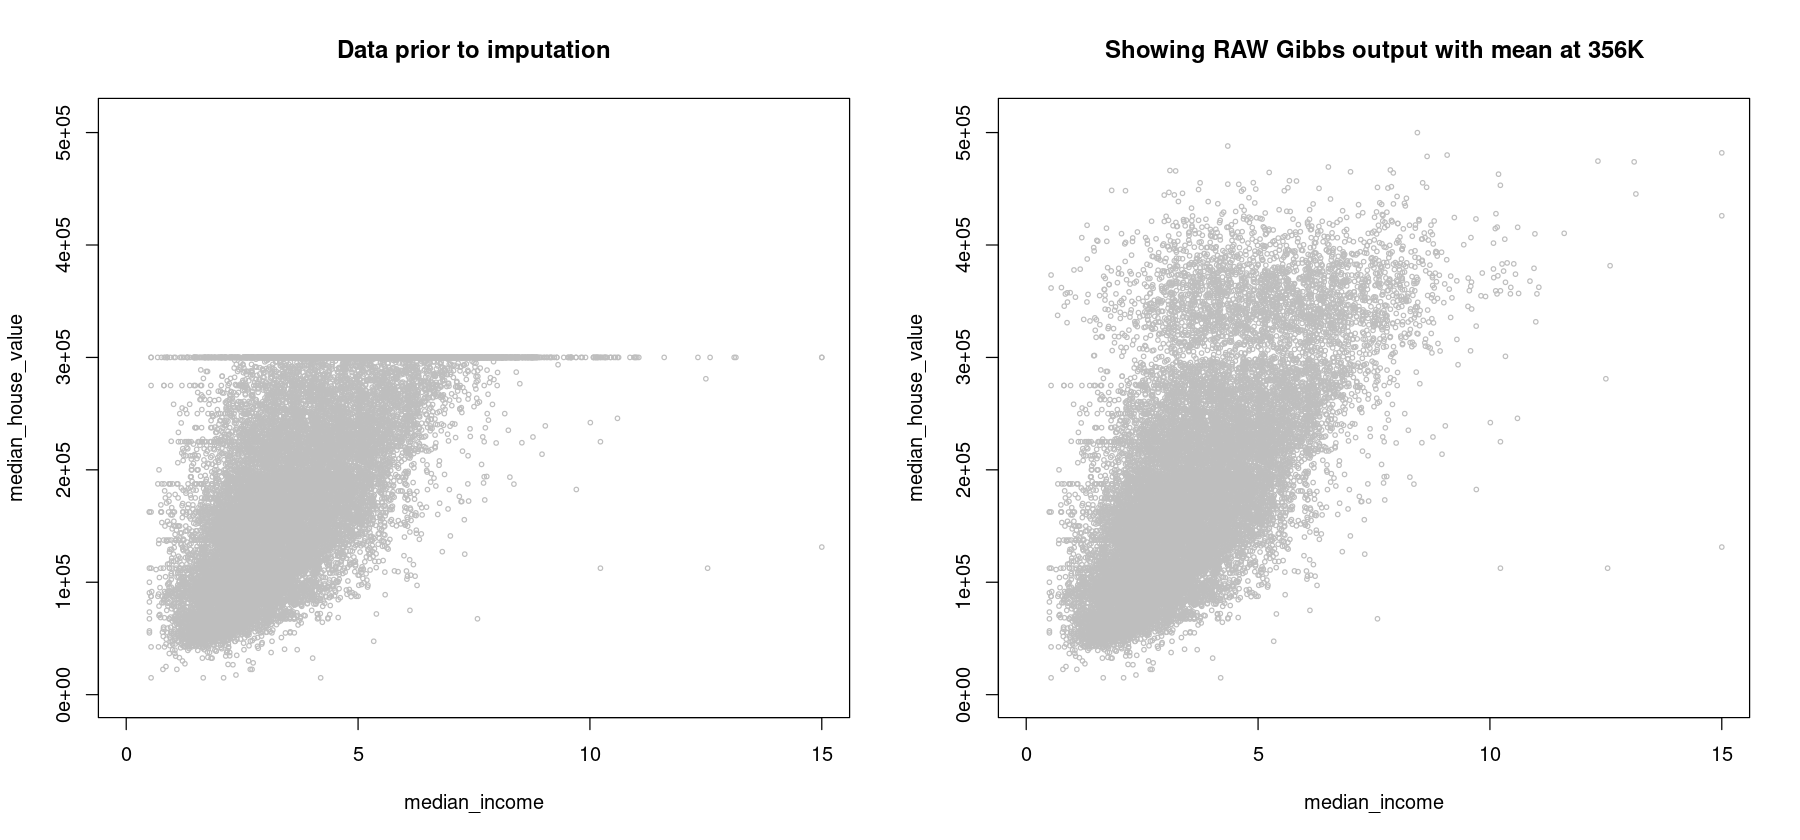

In [44]:
# Plot both before and after, where we use the adjusted values for "after".

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$median_income, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.51e06), xlim= c(0, 15),
     main= "Data prior to imputation")


# plot the newly predicted values
plot(newdat_raw$median_income, newdat_raw$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.51e06), xlim= c(0, 15),
     main= "Showing RAW Gibbs output with mean at 356K")


### Adjust the Gibbs sampler output based on our current prediction of the mean

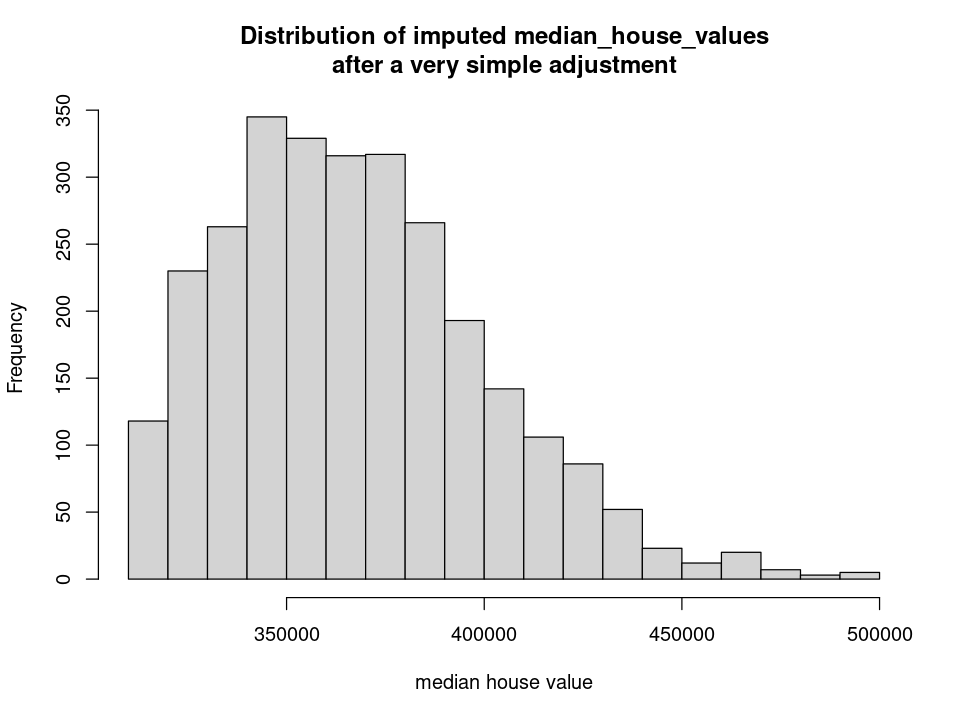

In [45]:
# Adjust the predictions so that the mean is closer to
# 368K.  Set the upper limit to where the Gibbs sampler
# currently puts it.  If we do not do this, the RSS scores
# we obtain will not be a fair comparison.

z_preds_adj <- z_preds + 12000
preds_adj <- ifelse(z_preds_adj > 500000, 500000, z_preds_adj)

options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=14, main="Distribution of imputed median_house_values
after a very simple adjustment",xlab="median house value")


In [46]:
# The mean is now about where we expect it to be.

summary(preds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 312020  343200  364240  367795  387694  500000 

In [47]:
# Assign imputed values.

newdat_adj <- dat
newdat_adj$median_house_value[censored] <- preds_adj
summary(newdat_adj$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  116300  173400  191424  247575  500000 

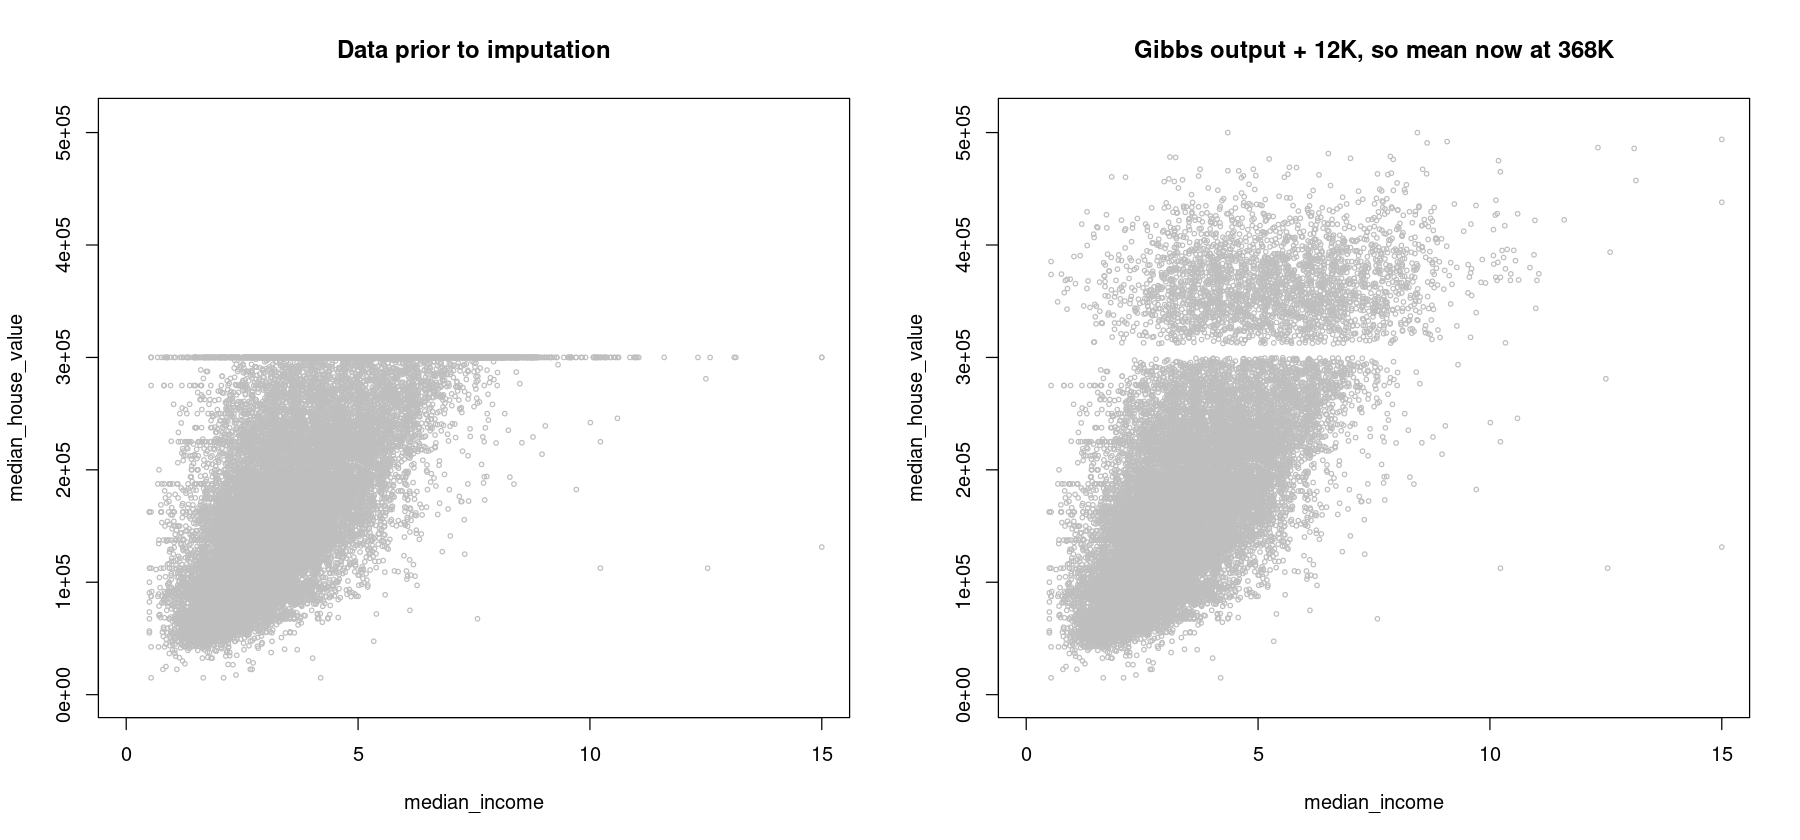

In [48]:
# Plot both before and after, where we use the adjusted values for "after".

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$median_income, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.51e06), xlim= c(0, 15),
     main= "Data prior to imputation")


# plot the newly predicted values
plot(newdat_adj$median_income, newdat_adj$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.51e06), xlim= c(0, 15),
     main= "Gibbs output + 12K, so mean now at 368K")


In [ ]:
### COMMENTS:

# Because we moved the Gibbs output to the right rather than 
# the left, we now have more white space between the imputed
# values and the non-imputed values.  The band of white space
# is not at all what we expect.  We can reduce this white space
# by adjusting z_means prior to calling rnorm.trunc03.


### Adjust RAW output and leave resulting shape as is

In [62]:
# We need to use a value a bit lower than 368K here in order
# to yield a final mean of 368K.

(z_means_bar <- mean(z_means))

z_means_adj <- z_means + (364500^response_var_power - z_means_bar)
summary(z_means_adj)
round(mean(z_means_adj)^inv_pwr)


[1] 10842

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11098   11139   11149   11192   11161   14016 

[1] 364500

In [63]:
# Get some new, adjusted predictions. 

set.seed(1931)
preds_adj <- round(rnorm.trunc03(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper), 5)
preds_adj <- round(preds_adj^inv_pwr)
summary(preds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300041  342605  365488  368154  389963  502194 

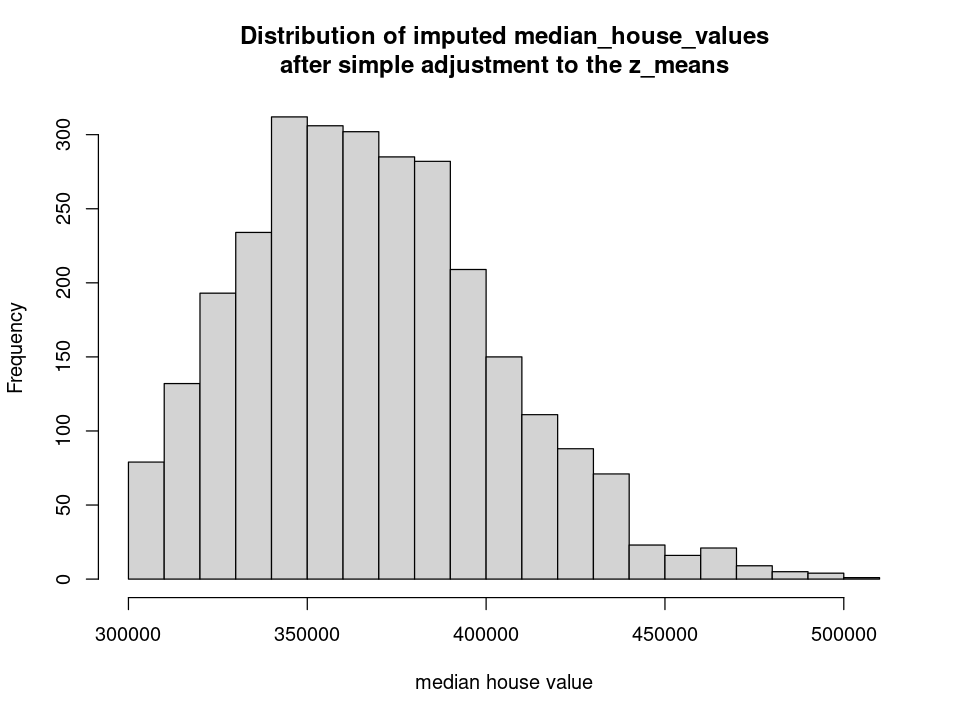

In [64]:
# The shape of the resulting distribution does not resemble
# the hypothesized shape found in Figure 2b.

options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=18, main="Distribution of imputed median_house_values
after simple adjustment to the z_means",xlab="median house value")


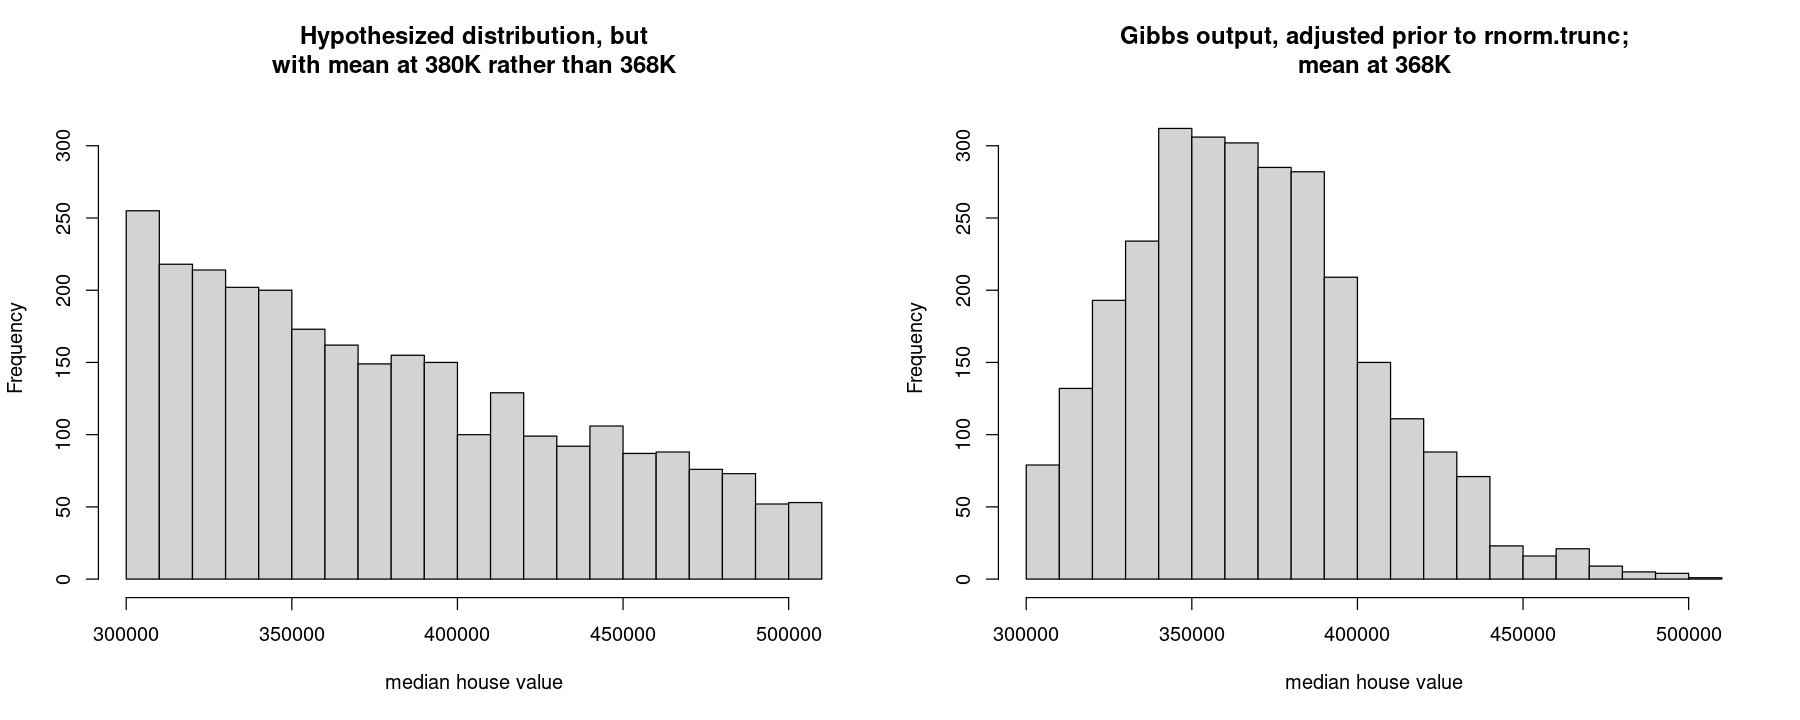

In [71]:
# Compare hypothesized distribution to the above distribution.

options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# Left panel.
hist(imputed_vals_tmp, breaks=20, main="Hypothesized distribution, but
with mean at 380K rather than 368K",
     ylim=c(0, 320), xlab="median house value")

# Right panel.
hist(preds_adj, breaks=20, main="Gibbs output, adjusted prior to rnorm.trunc;
mean at 368K",
     ylim=c(0, 320), xlab="median house value")


In [68]:
# Assign imputed values.

newdat_adj02 <- dat
newdat_adj02$median_house_value[censored] <- as.numeric(preds_adj)
summary(newdat_adj02$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  116300  173400  191476  247575  502194 

In [103]:
# Save to disk.

write.csv(newdat_adj02,
          file="/home/greg/Documents/stat/sandbox/. . ./datasets/housing/data_with_adj02_imputed_values_for_ppt.csv",
          row.names=TRUE)


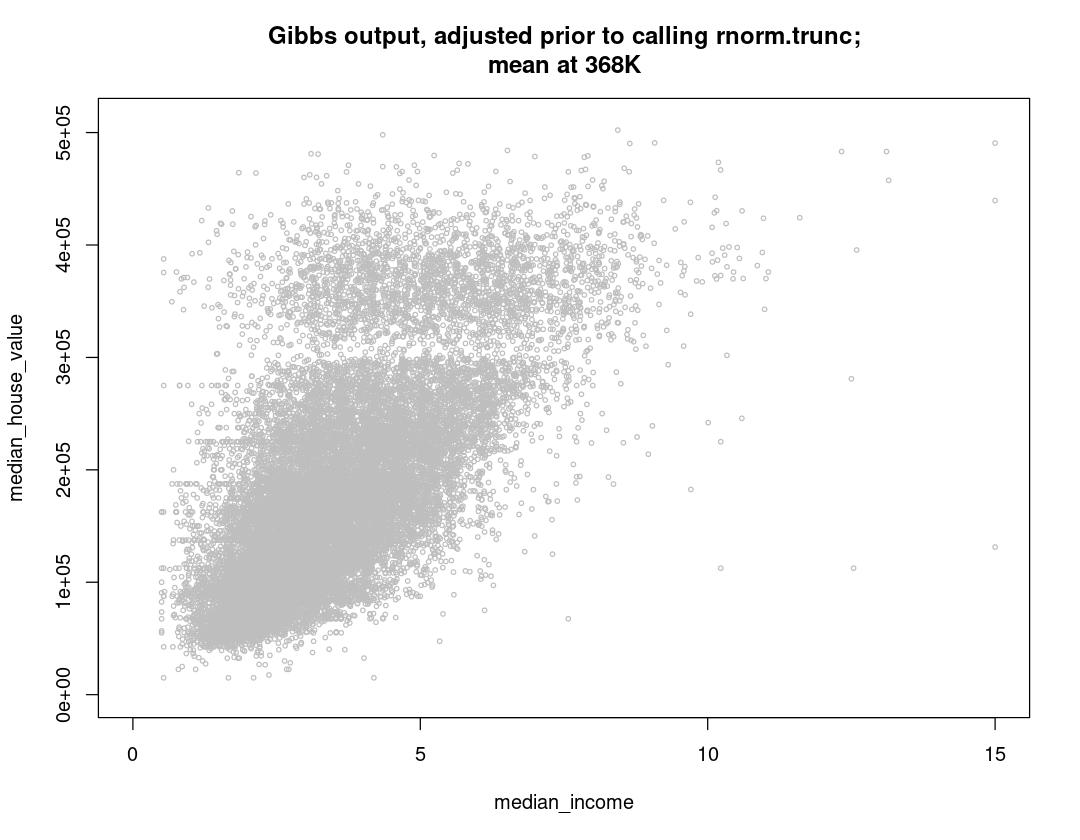

In [70]:
options(repr.plot.width= 9, repr.plot.height= 7)

# plot the newly predicted values
plot(newdat_adj02$median_income, newdat_adj02$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.51e06), xlim= c(0, 15),
     main= "Gibbs output, adjusted prior to calling rnorm.trunc;
mean at 368K")


In [ ]:
### COMMENTS:

# Note in the panel on the right above that we now have more 
# separation between the imputed and non-imputed values than what
# we saw with the RAW imputed values.  This, of course, is because
# we moved the mean of the distribution over to the right without
# trying to fill in the gap.  In other words, we moved the distri-
# bution over to the right without re-shaping it so that it looks
# more like our hypothesized example distribution in Figure 2b.

# If we attempt to reshape the adjusted output we now have so
# that the imputed values have a distribution which looks more like 
# the hypothesized distribution, the resulting predictions will be
# much worse (i.e., have a much greater RSS).

# While we can correct for the mean, we cannot (it seems) do much
# about the shape without degrading the quality of the imputed 
# values.  Thus, I leave the shape as is.


# Section 3: Get RSS scores and look at actual distribution

In this section we measure the quality of the imputed values in terms of an RSS score.  This is one further way to measure the quality of the imputed values.


In [29]:
dat <- read.csv("/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/data_with_adj02_imputed_values_for_ppt.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 7)))
dim(dat)

[1] 19574     7

### The distribution of the actual, unobserved (until now) values

In [30]:
# Compute the mean of the actual, unobserved values in the
# range of imputation.

dim(dat_noCap)
round(mean(dat_noCap[which(dat_noCap$median_house_value >= 300000),]$median_house_value))
# 368.4K


[1] 19574     7

[1] 368400

In [31]:
# Extract the unobserved, actual values.

unobserved_vals <- dat_noCap[which(dat_noCap$median_house_value >= 300000),]$median_house_value
length(unobserved_vals)


[1] 2833

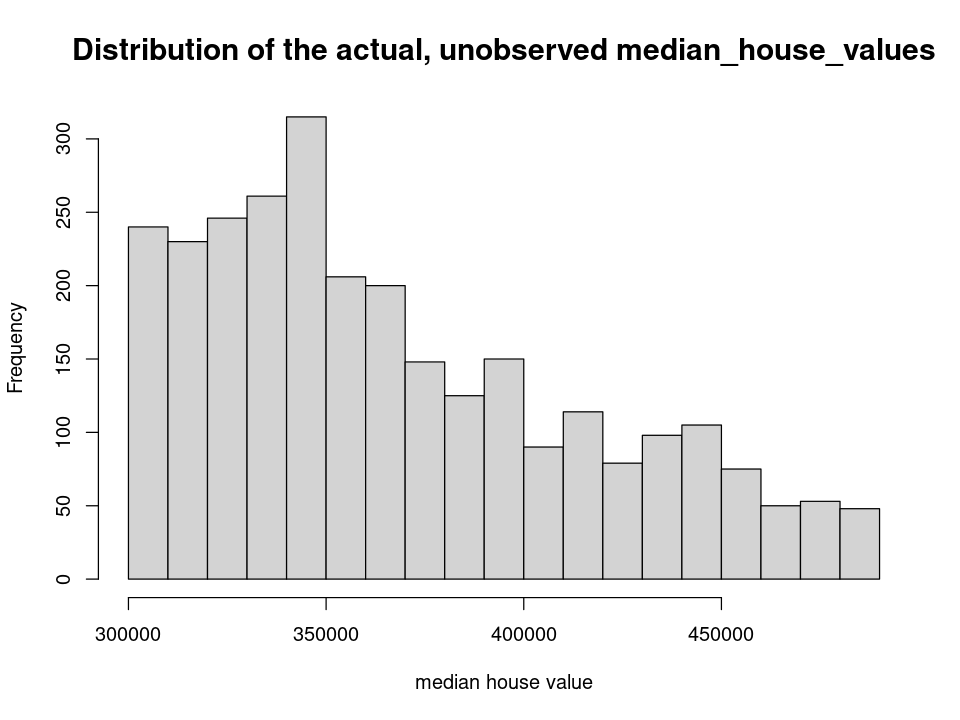

In [51]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(unobserved_vals, breaks=20, main="Distribution of the actual, unobserved median_house_values",
     xlab="median house value", cex.main=1.5)


### Comments

The mean of the actual, unobserved values happens to be right where model g02 predicted it to be but 12K away from the mean of our hypothesized distribution.  Keep in mind that the g02 prediction depends to a degree on the hypothesized distribution.  Also, we would not have gotten such a good prediction without: (a) using a window-size of 210K in combination with the 15K bin size; and (b) the excellent model diagnostics for g02, particularly the linearity of the residuals that we see in the q-q plot.  The Tukey test, the R-sqrd of 1, and the ncvTest are all not enough.  Notice in the residualPlots output that we have linearity with respect to every term in the model.  In other words, in order to get the good prediction that we did, we needed a "near-perfect" model.  

One would think that with the smooth curve we have in Figure 4 above, a curve we can generate for a lot of different kinds of censored data (see appendices A and B), we would generally have a high enough quality model to have great confidence in our model prediction.  Because of the dependency of the prediction on window size, this is not exactly true.  This is why referring back to the hypothesized distribution is so important.  Obviously, we can make slight adjustments to that distribution, changing where the mean lies.  If we see a great deal of variation in the mean when doing this, then we know that our model prediction can be a good prediction even if it does not align well with the mean predicted by the hypothesized distribution.


                                     * * * * *

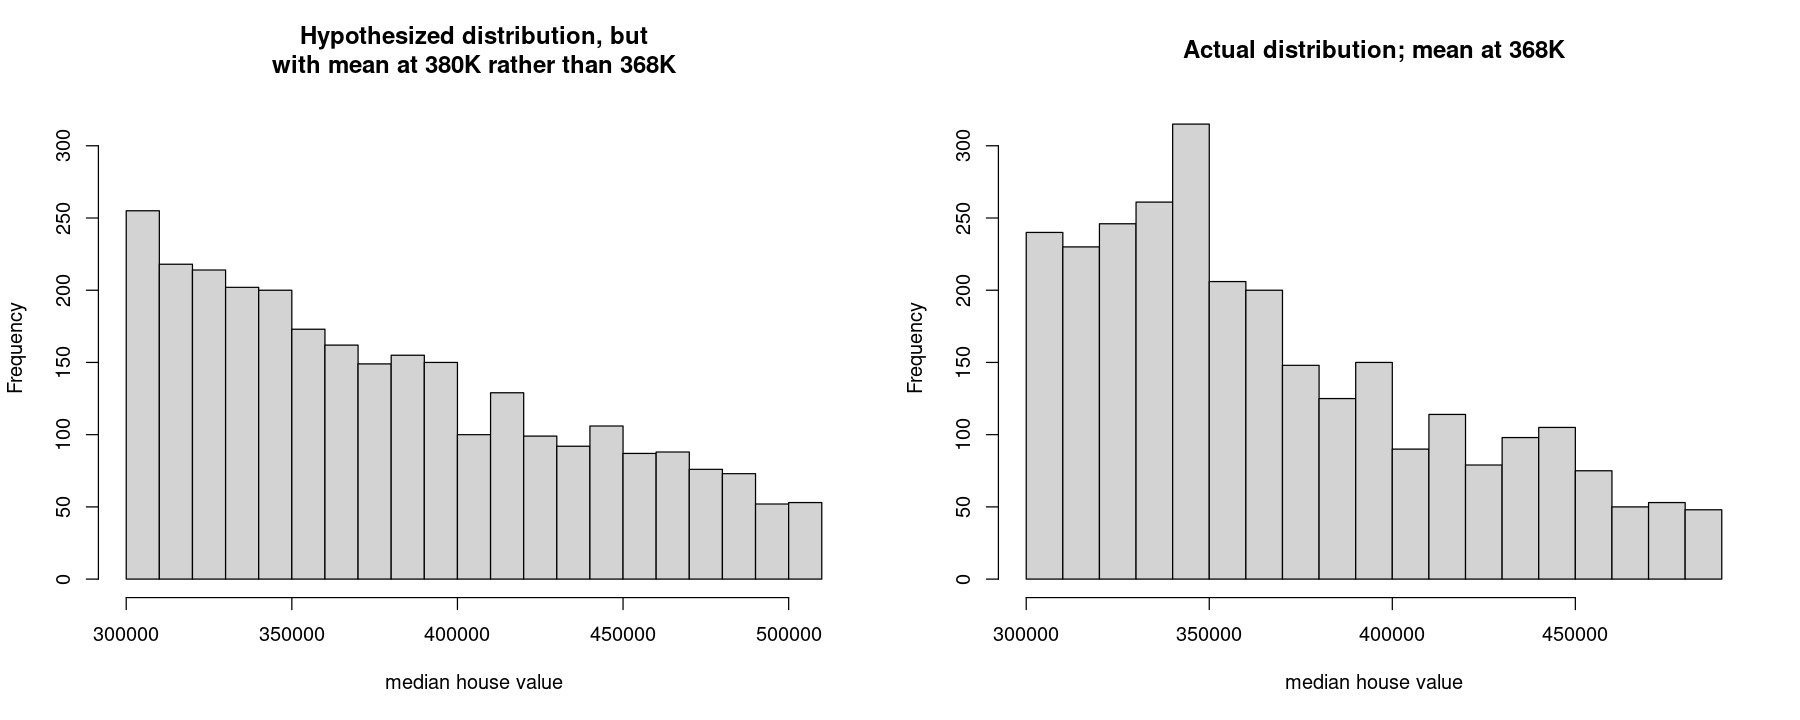

In [73]:
# Compare the above distribution with the hypothesized distribution.

options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# Left panel.
hist(imputed_vals_tmp, breaks=20, main="Hypothesized distribution, but
with mean at 380K rather than 368K",
     ylim=c(0, 320), xlab="median house value")

# Right panel.
hist(unobserved_vals, breaks=20, main="Actual distribution; mean at 368K",
     ylim=c(0, 320), xlab="median house value")


In [32]:
actual_vals <- unobserved_vals
names(actual_vals) <- rownames(dat_noCap[which(dat_noCap$median_house_value >= 300000),])
print(c(head(actual_vals), tail(actual_vals)))


     1      2      3      4      5    104  20502  20503  20504  20505  20528 
452600 358500 352100 341300 342200 350000 335000 325000 330000 343900 310000 
 20534 
326500 


### Compute the RSS gain for the original Gibbs output

RSS gain = 1 - \[RSS for predicted values / RSS for capped values\]


In [53]:

df02 <- read.csv("/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/data_with_raw_imputed_values_for_ppt.csv",
                 header=TRUE, row.names=1,
                 colClasses= c("character", rep("numeric", 7)))
dim(df02)


[1] 19574     7

In [54]:
# Extract the imputed values.

df02_imputed_vals <- df02[which(df02$median_house_value >= 300000),]$median_house_value
names(df02_imputed_vals) <- rownames(df02[which(df02$median_house_value >= 300000),])
print(head(df02_imputed_vals))


     1      2      3      4      5    104 
407799 393808 428675 450906 349803 317228 


In [55]:
# Compute the RSS for these imputed values.

gibbs01_rss <- round(sum((actual_vals[rows_censored] - df02_imputed_vals[rows_censored])^2))
paste0("RSS score for the unadjusted, RAW-01 Gibbs values: ", as.character(gibbs01_rss))


[1] "RSS score for the unadjusted, RAW-01 Gibbs values: 9835138727031"

In [57]:
# Compute the RSS for the capped values.

cap_rss <- round(sum((actual_vals[rows_censored] - 300000)^2))


In [58]:
# Compute the RSS gain for the original Gibbs output.
# This is a measure of how much we have reduced the noise
# in the capped values.

# RSS gain = 1 - [RSS for predicted values / RSS for capped values]

(gibbs01_RSSgain <- round(1 - gibbs01_rss/cap_rss, 4))
# 0.5081


[1] 0.5081

### Compute the RSS gain for the adjusted output from the first Gibbs sampler

This set of imputed values is adjusted so that the mean of the Gibbs sampler output is at 368K.  But the distribution is not re-shaped to be closer to the hypothesized distribution.

In [59]:

df03 <- read.csv("/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/data_with_adj02_imputed_values_for_ppt.csv",
                 header=TRUE, row.names=1,
                 colClasses= c("character", rep("numeric", 7)))
dim(df03)


[1] 19574     7

In [60]:
# Extract the imputed values.

df03_imputed_vals <- df03[which(df03$median_house_value >= 300000),]$median_house_value
names(df03_imputed_vals) <- rownames(df03[which(df03$median_house_value >= 300000),])
print(head(df03_imputed_vals))


     1      2      3      4      5    104 
422875 408409 444215 466520 362972 326097 


In [61]:
# Compute the RSS for these imputed values.

gibbs01_adj_rss <- round(sum((actual_vals[rows_censored] - df03_imputed_vals[rows_censored])^2))
paste0("RSS score for the adjusted, RAW-01 Gibbs values: ", as.character(gibbs01_adj_rss))


[1] "RSS score for the adjusted, RAW-01 Gibbs values: 9817368770389"

In [62]:
gibbs01_adj_rss > gibbs01_rss


[1] FALSE

In [63]:
# The gibbs01_adj_rss is smaller.  What is the delta?

delta <- gibbs01_rss - gibbs01_adj_rss

# Compute the percent reduction:
round(delta/gibbs01_rss, 4)


[1] 0.0018

In [64]:
# Compute the RSS gain.

(gibbs01_adj_RSSgain <- round(1 - gibbs01_adj_rss/cap_rss, 4))
# 0.5090


[1] 0.509

In [ ]:
### COMMENTS:

# The RSS gain of the adjusted distribution is almost identical 
# to that of the original Gibbs output.  On average, we haven't 
# upset the predictions in the process of re-adjusting the mean.

# But it is also true that, on average, we haven't really improved
# the predictions.  This is so even though we have moved the mean
# over to the right by 12K.


### Compute the RSS gain when all imputed values are set to the predicted mean of 368K

Because our prediction for the mean is spot-on, this gain will be quite high.

In [65]:
# Compute the RSS for these imputed values.

predicted_mean_rss <- round(sum((actual_vals[rows_censored] - 368000)^2))


In [66]:
# Compute the RSS gain.

(predicted_mean_RSSgain <- round(1 - predicted_mean_rss/cap_rss, 4))
# 0.3674


[1] 0.6629

In [ ]:
### COMMENT:

# If we measure by RSS alone, our current best set of imputed 
# values is one where all are set to the predicted mean.  This 
# has to do in part with the fact that our prediction for the
# mean is so good.


# Section 4: Does Gibbs output improve if we replace the capped values with NAs?

In [67]:
dat <- dat_noCap

dat[which(dat$median_house_value >= 300000), c("median_house_value")] <- NA

nrow(dat) - nrow(na.omit(dat))
# We should see 2833 NAs.


[1] 2833

In [236]:
# The following model is used in the Gibbs sampler that follows.

m02 <- lm(I(median_house_value^0.703) ~ 
          
           I(median_income^-3.79) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           I(pop_per_hh^1.5) +
           I(pop_per_hh^3.0) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
          data= dat)

m02.summary <- summary(m02)
m02.summary[[1]] <- ""; round(m02.summary$adj.r.squared, 3)


[1] 0.628

In [237]:
ncvTest(m02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.16407, Df = 1, p = 0.685

In [238]:
residualPlots(m02, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^-3.79)         -0.97            0.331
I(long_transf^-0.5)             1.90            0.057
I(long_transf^-1)              11.79          < 2e-16
I(long_transf^-1.5)            12.14          < 2e-16
latitude                        0.69            0.489
I(latitude^2)                  -0.62            0.537
I(latitude^3)                  34.34          < 2e-16
I(latitude^4)                  34.34          < 2e-16
I(pop_per_hh^1.5)              -0.07            0.945
I(pop_per_hh^3)                -7.02          2.3e-12
I(housing_median_age^0.15)     -2.49            0.013
HHdens_ln                       4.73          2.2e-06
Tukey test                      0.76            0.448


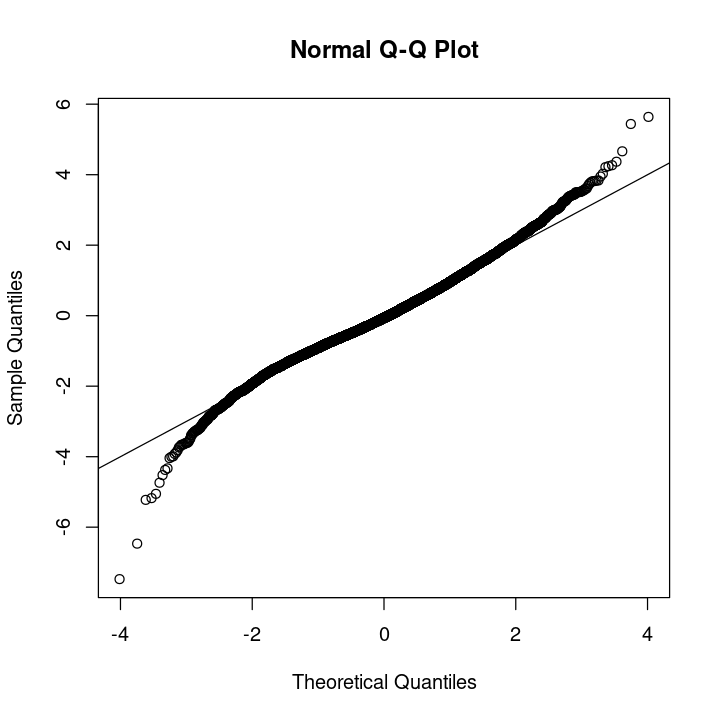

In [239]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(m02, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [240]:
# Get a sense of the uncertainty for the model's sigma.

m02.sim <- sim(m02, n.sims=3000)


In [241]:
# Sigma is small because of the power transformation 
# on the response variable.

sigma.m02.sim <- sigma.hat(m02.sim)
str(sigma.m02.sim)


 num [1:3000] 805 802 807 806 801 ...


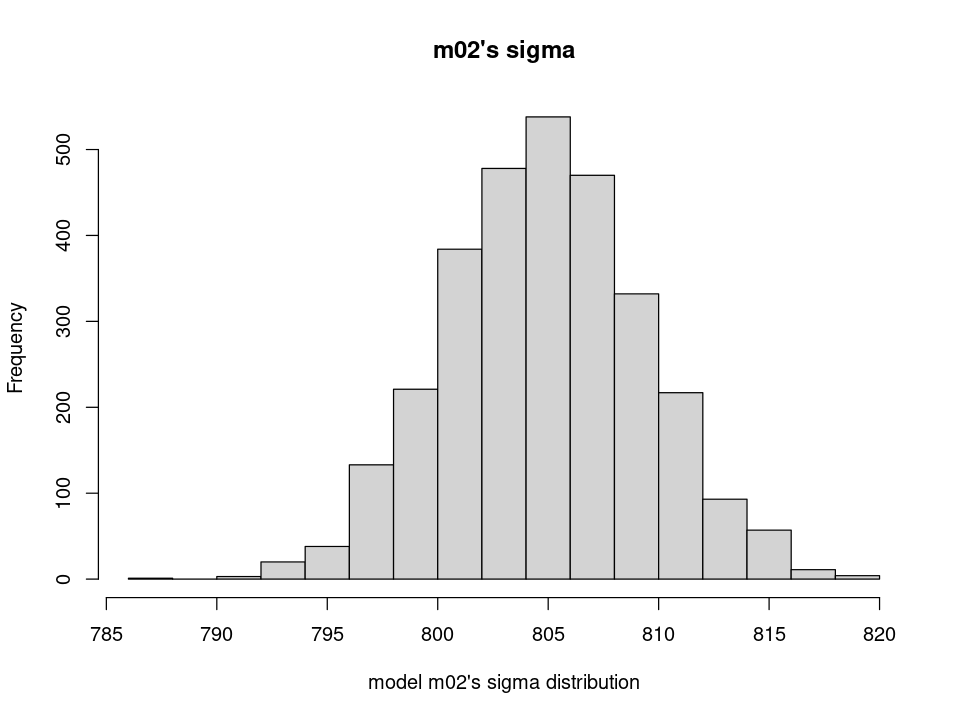

In [242]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(sigma.m02.sim, breaks=20, main="m02's sigma",
     xlab="model m02's sigma distribution")


### Gibbs sampler for imputing censored median house values

In [244]:
cap <- 300000
response_var_power <- 0.703
inv_pwr <- 1/response_var_power

C <- cap^response_var_power
C_upper <- (1.68*cap)^response_var_power

censored <- is.na(dat$median_house_value)

# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$median_house_value)^response_var_power)
z[censored] <- runif(n.censored, C, C_upper)


In [245]:
length(censored)
n.censored


[1] 19574

[1] 2833

In [246]:
summary(z[censored])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7087    7894    8669    8654    9421   10205 

In [247]:
# Identify the rows that are censored.

rows_censored <- rownames(dat)[censored]
c(head(rows_censored), tail(rows_censored))


[1] "1"     "2"     "3"     "4"     "5"     "104"   "20502" "20503" "20504"
[10] "20505" "20528" "20534"

In [159]:
# Function to draw from a constrained normal distribution.

rnorm.trunc03 <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need each mu to be >= C.  Otherwise the return 
    # value will be Inf.
    cap <- 300000
    mu02 <- ifelse(mu <= C, (cap + 100)^response_var_power, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [249]:
# Create matrix X for the terms in our model.

X <- dat

X$median_income <- (X$median_income)^-3.79

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$long_1 <- (X$long_transf)^-0.5
X$long_2 <- (X$long_transf)^-1
X$long_3 <- (X$long_transf)^-1.5

X$pphh1 <-  (X$pop_per_hh)^1.5
X$pphh2 <- (X$pop_per_hh)^3.0

X$housing_median_age <- (X$housing_median_age)^0.15

X$HHdens_by_long <- X$HHdens_ln * X$long_transf
X$HHdens_by_income <- X$HHdens_ln * X$median_income
X$HHdens_3way <- X$HHdens_ln * X$median_income * X$housing_median_age



X <- X[, c("median_income","long_1","long_2","long_3","latitude","lat2",
           "lat3","lat4","pphh1","pphh2", "housing_median_age",
           "HHdens_ln", "HHdens_by_long","HHdens_by_income",
           "HHdens_3way")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 19574    16

[1] "intercept"          "median_income"      "long_1"            
 [4] "long_2"             "long_3"             "latitude"          
 [7] "lat2"               "lat3"               "lat4"              
[10] "pphh1"              "pphh2"              "housing_median_age"
[13] "HHdens_ln"          "HHdens_by_long"     "HHdens_by_income"  
[16] "HHdens_3way"

In [250]:
# See p.406 (Section 18.5) of Gelman and Hill's book,
# "Data Analysis Using Regression and Multilevel/Hierarchical
# Models".

# Fit a regression using the crude starting values of z.

m02_tst <- lm(z ~ 
             
           I(median_income^-3.79) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           I(pop_per_hh^1.5) +
           I(pop_per_hh^3.0) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
              
           data= dat)    

# Obtain a sample draw of the model coefficients and of
# parameter sigma.
sim.1 <- sim(m02_tst, n.sims=1)


In [251]:
beta <- coef(sim.1)
dim(beta)
colnames(beta)


[1]  1 16

[1] "(Intercept)"                               
 [2] "I(median_income^-3.79)"                    
 [3] "I(long_transf^-0.5)"                       
 [4] "I(long_transf^-1)"                         
 [5] "I(long_transf^-1.5)"                       
 [6] "latitude"                                  
 [7] "I(latitude^2)"                             
 [8] "I(latitude^3)"                             
 [9] "I(latitude^4)"                             
[10] "I(pop_per_hh^1.5)"                         
[11] "I(pop_per_hh^3)"                           
[12] "I(housing_median_age^0.15)"                
[13] "HHdens_ln"                                 
[14] "HHdens_ln:long_transf"                     
[15] "HHdens_ln:median_income"                   
[16] "HHdens_ln:median_income:housing_median_age"

In [252]:
# Here are means for 6 different normal distributions.

means <- as.matrix(X) %*% t(beta)
length(means)
round(head(as.vector(means)^inv_pwr))


[1] 19574

[1] 111263 119351  78916  80356  88110  88745

In [253]:
# All values should be between 300K and 504K
z.old <- z[censored]
round(head(z.old)^inv_pwr)


[1] 370015 477134 402694 322302 322248 377303

In [254]:
# All values should be between 300K and 504K.
sigma <- sigma.hat(sim.1)
round(sigma, 4)

z.new <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
round(head(as.vector(z.new)^inv_pwr))


[1] 1172.4

[1] 369059 332350 374279 320307 304603 469512

In [255]:
summary(z.new^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300047  322457  348370  356404  380898  502100 

In [256]:
# For the Gibbs sampler, the above is now put into
# a loop.  We first test with 100 iterations.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

# We have 16 terms in the model (including the intercept) as
# well as parameter sigma.  Thus, besides storing the imputed
# values, we need to have 17 additional slots.
sims <- array(NA, c(n.iter, n.chains, 17 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        m02.1 <- lm(z ~ 
                    
           I(median_income^-3.79) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           I(pop_per_hh^1.5) +
           I(pop_per_hh^3.0) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)   
        
        sim.1 <- sim(m02.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        stopifnot(sum(z[censored] < Inf) == n.censored)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.74 minutes.


Time difference of 4.74 mins

In [ ]:
# Check for convergence.

# sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
# print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [257]:
save(sims, file="/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims02_raw_hhvals_300Kcap.RData")


In [32]:
load("/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims02_raw_hhvals_300Kcap.RData")


In [258]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 2850

In [259]:
sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [260]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 7885.0 7885.0 7893.2 7883.9 7883.5 7875.4

[1] 588.58 590.81 601.41 598.67 587.16 597.46

In [261]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7855    7880    7886    7887    7892    9533 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    539     592     597     597     602     728 

In [262]:
summary(round(z_means^inv_pwr))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 347322  348875  349270  349334  349663  457459 

In [263]:
# Average estimate of the sd.

(sd_estimate <- round((7887 + 597)^inv_pwr) - round(7887^inv_pwr))
# 38,209


# When the capped values were used in the modeling, this value
# was $37,027


[1] 38209

In [264]:
# Here is a fuller summary for the stddevs.

ans <- round((z_means + z_sds)^inv_pwr) - round(z_means^inv_pwr)
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  36715   37891   38224   38224   38554   49301 

In [ ]:
### COMMENTS:

# Based on the prediction from g02, we expect the mean 
# to be about 368K if the upper limit is around 504K.  
# The mean is currently around 356.7K (see next summary).

# When the capped values were used in the modeling, this
# value was 355.8K.  The difference is likely due solely
# to sampling variation.


In [265]:
# Get some predictions, using rnorm.trunc03.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)

# Notice that the mean is at 356.7K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300021  331923  353005  356655  377036  493545 

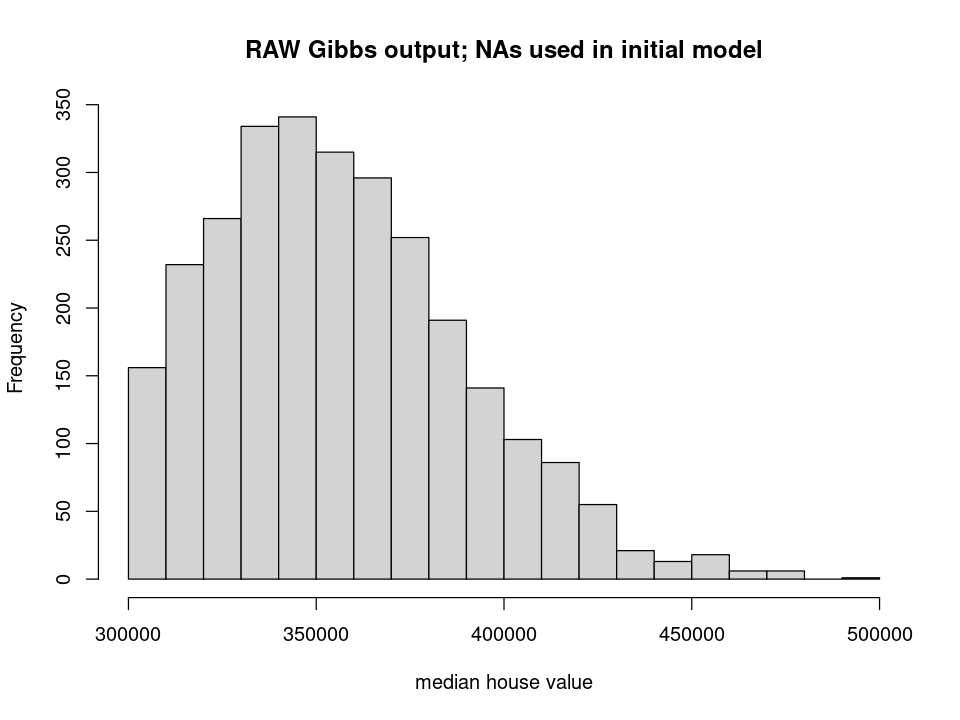

In [266]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, main="RAW Gibbs output; NAs used in initial model",
     xlab="median house value")


### Compute the RSS gain

In [268]:
names(z_preds) <- rownames(dat[censored,])
print(head(z_preds))


1      2      3      4      5    104 
389817 371309 436158 459217 352240 318349

In [269]:
# Compute the RSS gain.

gibbs02_rss <- round(sum((actual_vals[rows_censored] - z_preds[rows_censored])^2))
(gibbs02_RSSgain <- round(1 - gibbs02_rss/cap_rss, 4))
# 0.4859

# When the capped values were used in the intial model (m01), this
# score was 50.8%.  I think we would have to run this test many
# times to determine if there is a real difference.  For now I will
# assume that the null hypothesis stands: i.e., that there is no
# difference.


[1] 0.4859

In [ ]:
### COMMENT:

# I thought we would have seen a difference since the 
# capped records contain information.  So I would have
# expected to see a smaller RSS gain when we replace
# the capped values with NAs. 


# Section 5: Does RSS gain of Gibbs output improve if cap is set to 368K?

The best RSS gain we have seen thus far is when the imputed values are all set to 368K.  If our initial model for the Gibbs sampler is tuned when the cap is at 368K, do we get output with an RSS gain noticeably higher than 50\%?

In [271]:
censored_rows <- rownames(dat_noCap[which(dat_noCap$median_house_value >= 300000),])
length(censored_rows)

# Set cap to 368K.
dat_wCap <- dat_noCap
dat_wCap[censored_rows,]$median_house_value <- 368000


[1] 2833

In [272]:
dat <- dat_wCap


In [273]:
# Fit a new model.

lm03 <- lm(I(median_house_value^0.241) ~ 
          
           I(median_income^0.952) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat) 

lm03.summary <- summary(lm03)
lm03.summary[[1]] <- ""; round(lm03.summary$adj.r.squared, 3)


[1] 0.701

In [274]:
ncvTest(lm03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 4.476e-05, Df = 1, p = 0.995

In [275]:
residualPlots(lm03, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.952)        -12.19          < 2e-16
I(long_transf^-0.5)             1.65          0.09875
I(long_transf^-1)              11.41          < 2e-16
I(long_transf^-1.5)            11.81          < 2e-16
latitude                       -0.61          0.54104
I(latitude^2)                   0.17          0.86159
I(latitude^3)                  33.68          < 2e-16
I(latitude^4)                  33.67          < 2e-16
pop_per_hh                      0.55          0.58085
I(pop_per_hh^2)                -8.91          < 2e-16
I(housing_median_age^0.15)     -3.82          0.00013
HHdens_ln                       8.92          < 2e-16
Tukey test                     -0.47          0.63544


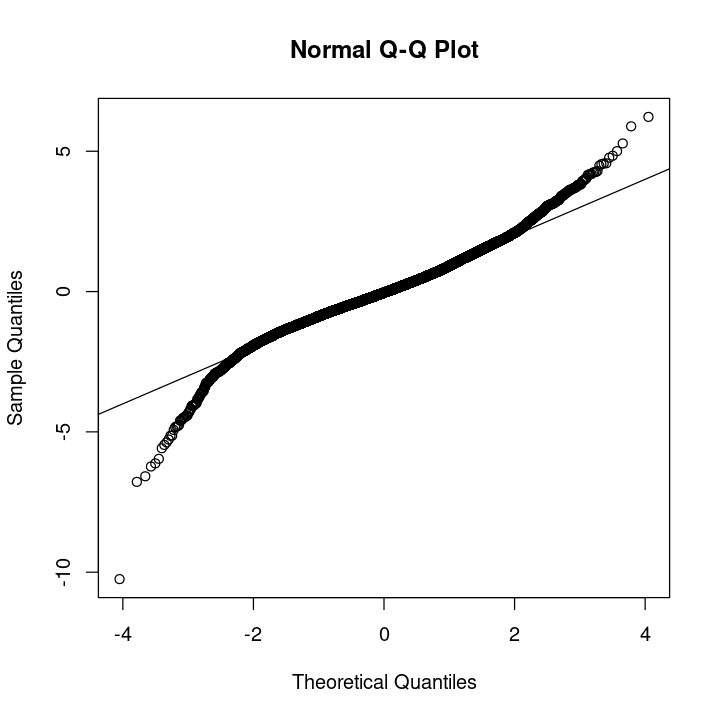

In [276]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(lm03, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


### Re-run Gibbs sampler

In [277]:
cap <- 300000
response_var_power <- 0.241
inv_pwr <- 1/response_var_power

C <- cap^response_var_power
C_upper <- (1.68*cap)^response_var_power

censored <- (dat$median_house_value)^response_var_power >= C

# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$median_house_value)^response_var_power)
z[censored] <- runif(n.censored, C, C_upper)


In [278]:
length(censored)
n.censored


[1] 19574

[1] 2833

In [279]:
summary(z[censored])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   20.9    21.6    22.3    22.3    23.0    23.7 

In [280]:
# Identify the rows that are censored.

rows_censored <- rownames(dat)[censored]
c(head(rows_censored), tail(rows_censored))
length(rows_censored)


[1] "1"     "2"     "3"     "4"     "5"     "104"   "20502" "20503" "20504"
[10] "20505" "20528" "20534"

[1] 2833

In [83]:
# Create matrix X for the terms in our model.

X <- dat

X$median_income <- (X$median_income)^0.952

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$long_1 <- (X$long_transf)^-0.5
X$long_2 <- (X$long_transf)^-1
X$long_3 <- (X$long_transf)^-1.5

X$pphh1 <-  X$pop_per_hh
X$pphh2 <- (X$pop_per_hh)^2

X$housing_median_age <- (X$housing_median_age)^0.15

X$HHdens_by_long <- X$HHdens_ln * X$long_transf
X$HHdens_by_income <- X$HHdens_ln * X$median_income
X$HHdens_3way <- X$HHdens_ln * X$median_income * X$housing_median_age



X <- X[, c("median_income","long_1","long_2","long_3","latitude","lat2",
           "lat3","lat4","pphh1","pphh2", "housing_median_age",
           "HHdens_ln", "HHdens_by_long","HHdens_by_income",
           "HHdens_3way")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 19574    16

[1] "intercept"          "median_income"      "long_1"            
 [4] "long_2"             "long_3"             "latitude"          
 [7] "lat2"               "lat3"               "lat4"              
[10] "pphh1"              "pphh2"              "housing_median_age"
[13] "HHdens_ln"          "HHdens_by_long"     "HHdens_by_income"  
[16] "HHdens_3way"

In [84]:
# Fit a regression using the crude starting values of z.

lm02_tst <- lm(z ~ 
             
           I(median_income^0.952) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
              
           data= dat)    

# Obtain a sample draw of the model coefficients and of
# parameter sigma.
sim.1 <- sim(lm02_tst, n.sims=1)


In [85]:
beta <- coef(sim.1)
dim(beta)
colnames(beta)


[1]  1 16

[1] "(Intercept)"                               
 [2] "I(median_income^0.952)"                    
 [3] "I(long_transf^-0.5)"                       
 [4] "I(long_transf^-1)"                         
 [5] "I(long_transf^-1.5)"                       
 [6] "latitude"                                  
 [7] "I(latitude^2)"                             
 [8] "I(latitude^3)"                             
 [9] "I(latitude^4)"                             
[10] "pop_per_hh"                                
[11] "I(pop_per_hh^2)"                           
[12] "I(housing_median_age^0.15)"                
[13] "HHdens_ln"                                 
[14] "HHdens_ln:long_transf"                     
[15] "HHdens_ln:median_income"                   
[16] "HHdens_ln:median_income:housing_median_age"

In [86]:
# Here are means for 6 different normal distributions.

means <- as.matrix(X) %*% t(beta)
length(means)
round(head(as.vector(means)^inv_pwr))


[1] 19574

[1] 421861 446973 306977 252441 206762 214103

In [87]:
# All values should be between 300K and 504K
z.old <- z[censored]
round(head(z.old)^inv_pwr)


[1] 479014 415101 437347 487274 469520 323740

In [88]:
# All values should be between 300K and 504K.
sigma <- sigma.hat(sim.1)
round(sigma, 4)

z.new <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
round(head(as.vector(z.new)^inv_pwr))


[1] 1.335

[1] 462980 404653 313710 364093 309387 455690

In [89]:
summary(z.new^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300010  329071  362983  372447  405358  503601 

In [90]:
# For the Gibbs sampler, the above is now put into
# a loop.  We first test with 100 iterations.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

# We have 16 terms in the model (including the intercept) as
# well as parameter sigma.  Thus, besides storing the imputed
# values, we need to have 17 additional slots.
sims <- array(NA, c(n.iter, n.chains, 17 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        m01.1 <- lm(z ~ 
                    
           I(median_income^0.952) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)   
        
        sim.1 <- sim(m01.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        stopifnot(sum(z[censored] < Inf) == n.censored)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.28 minutes.


Time difference of 4.28 mins

In [ ]:
# Check for convergence.

# sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
# print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [91]:
save(sims, file="/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims_raw04_hhvals_300Kcap.RData")


In [281]:
load("/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims_raw04_hhvals_300Kcap.RData")


In [282]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 2850

In [283]:
sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [284]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 22.27 22.41 21.86 21.82 21.83 21.84

[1] 0.75 0.73 0.68 0.66 0.67 0.67

In [285]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   21.8    21.8    21.8    21.9    21.9    23.4 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.271   0.666   0.671   0.678   0.680   0.751 

In [286]:
summary(round(z_means^inv_pwr))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 358026  360004  360665  364886  362025  479966 

In [287]:
# Average estimate of the sd.

(sd_estimate <- round((21.9 + 0.678)^inv_pwr) - round(21.9^inv_pwr))
# $49,193

# This estimate is 12K higher than what we saw when the cap
# was at 300K.


[1] 49193

In [288]:
# Here is a fuller summary for the stddevs.

ans <- round((z_means + z_sds)^inv_pwr) - round(z_means^inv_pwr)
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  23462   47786   48250   49223   49078   58458 

In [ ]:
### COMMENTS:

# Based on the prediction from g02, we expect the mean 
# to be about 368K if the upper limit is around 504K.  
# The mean is currently around 373K (see next summary).

# The new model, lm02, raised the mean of the Gibbs sampler 
# output from 356K to 373K.

# The 95% prediction interval for the 368K prediction
# is [361K, 376K]. 


In [289]:
# Get some predictions, using rnorm.trunc03.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)

# Notice that the mean is at 373.3K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300027  340504  368087  372798  399345  503508 

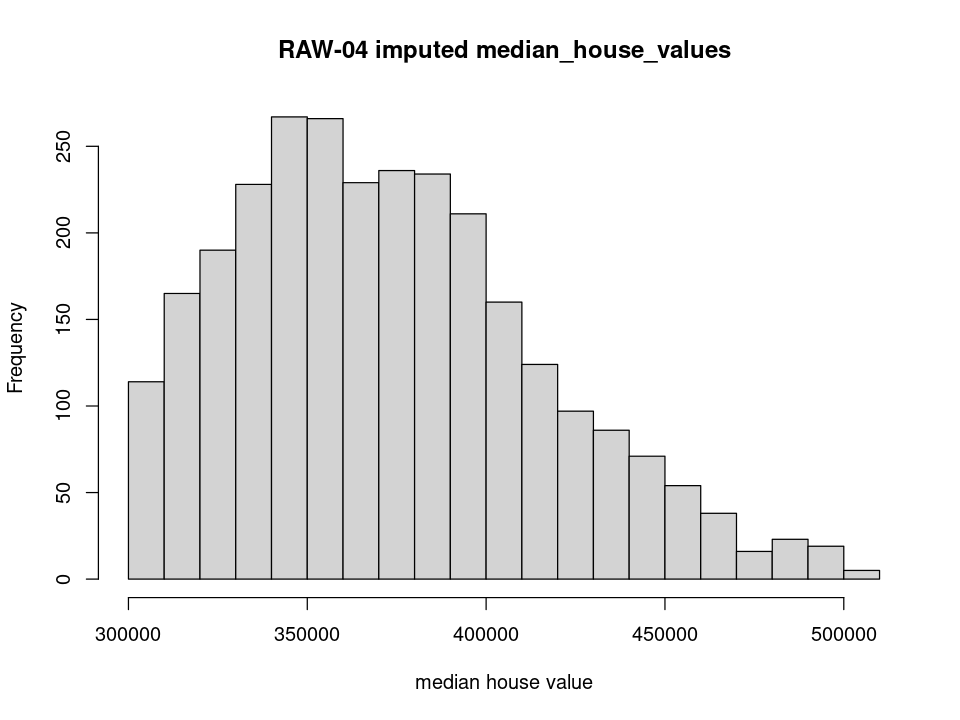

In [290]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, main="RAW-04 imputed median_house_values",
     xlab="median house value")


### Compute the RSS gain

In [291]:
names(z_preds) <- rownames(dat[censored,])
print(head(z_preds))


1      2      3      4      5    104 
444655 425969 470407 490588 362979 322799

In [292]:
# Compute the RSS gain.

gibbs04_rss <- round(sum((actual_vals[rows_censored] - z_preds[rows_censored])^2))
(gibbs04_RSSgain <- round(1 - gibbs04_rss/cap_rss, 4))
# 0.4346

# When the capped values were used in the intial model (m01), this
# score was 50.8%.  We are clearly worse off in terms of RSS gain
# when we start with a model which has the cap set to the predicted
# mean.


[1] 0.4346

# Section 6: Does RSS of Gibbs output improve using model with current best Gibbs output?

In the last few tests I have been trying to see if the model which the Gibbs sampler starts with makes a difference in terms of the quality of the Gibbs output.  The thought has been that if we build a model with NAs or with the censored data set to the cap (i.e., unchanged), we will not be able to get the best predictions out of the Gibbs sampler because it is using a model tuned to the wrong data.  Thus far we have been finding out that this is not the case.  But what if the model we start with is one which has imputed values output from a Gibbs sampler?  We have seen that the amount of noise in the capped data can be reduced by half or more when we replace the capped data with Gibbs output.

This is the same test as in Section 5, but now I model with a set of imputed values that is more realistically spread out.

If doing this once with the Gibbs output yields improvement, should we expect to be able to do this again with the newest Gibbs output and see even more improvement?  This seems highly unlikely since a lot of random sampling is involved, and after the first iteration I would think that the model tuning would change very little.

In [293]:

df03 <- read.csv("/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/data_with_adj02_imputed_values_for_ppt.csv",
                 header=TRUE, row.names=1,
                 colClasses= c("character", rep("numeric", 7)))
dim(df03)


[1] 19574     7

In [294]:
# Extract the imputed values.

df03_imputed_vals <- df03[which(df03$median_house_value >= 300000),]$median_house_value
names(df03_imputed_vals) <- rownames(df03[which(df03$median_house_value >= 300000),])
print(head(df03_imputed_vals))


     1      2      3      4      5    104 
422875 408409 444215 466520 362972 326097 


In [295]:
dat <- df03


In [306]:
lm05 <- lm(I(median_house_value^0.218) ~ 
          
           I(median_income^0.956) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat) 

lm05.summary <- summary(lm05)
lm05.summary[[1]] <- ""; round(lm05.summary$adj.r.squared, 3)


[1] 0.701

In [307]:
ncvTest(lm05)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.30696, Df = 1, p = 0.58

In [308]:
residualPlots(lm05, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.956)        -11.02          < 2e-16
I(long_transf^-0.5)             1.35          0.17647
I(long_transf^-1)              11.55          < 2e-16
I(long_transf^-1.5)            11.95          < 2e-16
latitude                        1.12          0.26218
I(latitude^2)                   0.16          0.87492
I(latitude^3)                  33.79          < 2e-16
I(latitude^4)                  33.78          < 2e-16
pop_per_hh                     -0.54          0.58651
I(pop_per_hh^2)                -8.82          < 2e-16
I(housing_median_age^0.15)     -3.38          0.00074
HHdens_ln                       8.91          < 2e-16
Tukey test                     -0.02          0.98750


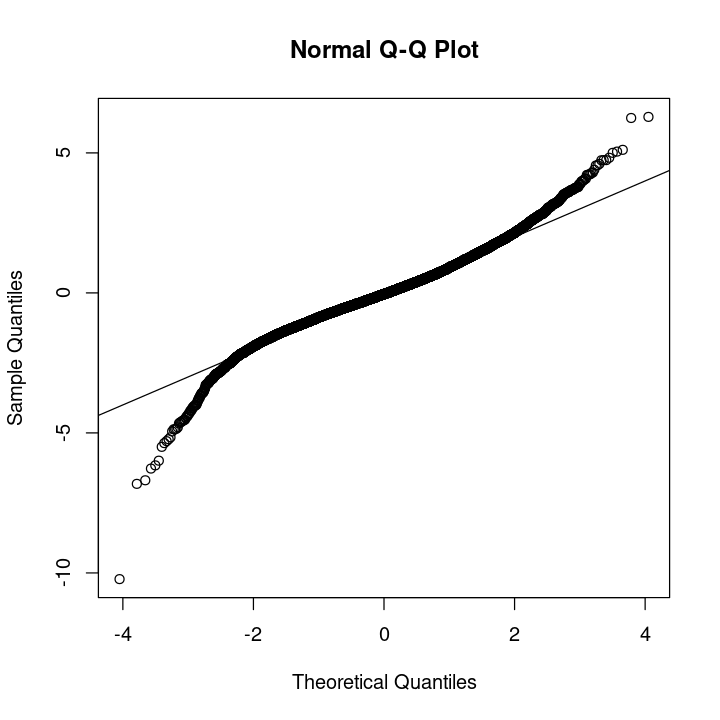

In [309]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(lm05, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [310]:
# Get a sense of the uncertainty for the model's sigma.
# (sim is from the arm package.)

lm05.sim <- sim(lm05, n.sims=3000)


In [311]:
# Sigma is small because of the power transformation 
# on the response variable.

sigma.lm05.sim <- sigma.hat(lm05.sim)
str(sigma.lm05.sim)


 num [1:3000] 0.864 0.865 0.856 0.856 0.861 ...


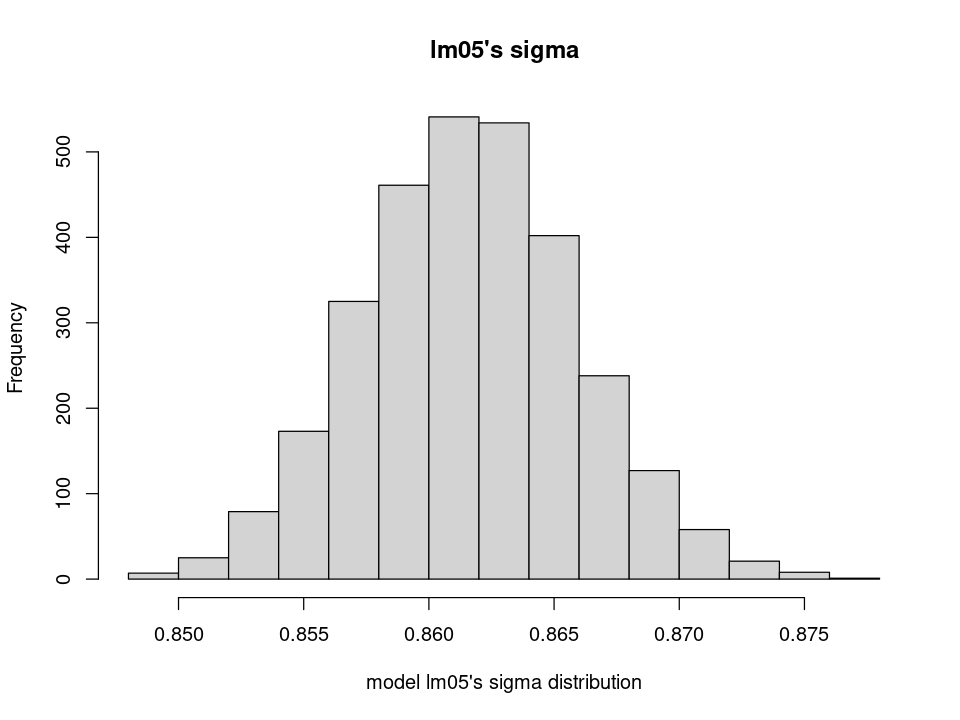

In [312]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(sigma.lm05.sim, breaks=20, main="lm05's sigma",
     xlab="model lm05's sigma distribution")


### Re-run Gibbs sampler

In [313]:
cap <- 300000
response_var_power <- 0.218
inv_pwr <- 1/response_var_power

C <- cap^response_var_power
C_upper <- (1.68*cap)^response_var_power

censored <- (dat$median_house_value)^response_var_power >= C

# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$median_house_value)^response_var_power)
z[censored] <- runif(n.censored, C, C_upper)


In [314]:
length(censored)
n.censored


[1] 19574

[1] 2833

In [315]:
summary(z[censored])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   15.6    16.1    16.6    16.6    17.0    17.5 

In [316]:
# Identify the rows that are censored.

rows_censored <- rownames(dat)[censored]
c(head(rows_censored), tail(rows_censored))


[1] "1"     "2"     "3"     "4"     "5"     "104"   "20502" "20503" "20504"
[10] "20505" "20528" "20534"

In [317]:
# Create matrix X for the terms in our model.

X <- dat

X$median_income <- (X$median_income)^0.956

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$long_1 <- (X$long_transf)^-0.5
X$long_2 <- (X$long_transf)^-1
X$long_3 <- (X$long_transf)^-1.5

X$pphh1 <-  X$pop_per_hh
X$pphh2 <- (X$pop_per_hh)^2

X$housing_median_age <- (X$housing_median_age)^0.15

X$HHdens_by_long <- X$HHdens_ln * X$long_transf
X$HHdens_by_income <- X$HHdens_ln * X$median_income
X$HHdens_3way <- X$HHdens_ln * X$median_income * X$housing_median_age



X <- X[, c("median_income","long_1","long_2","long_3","latitude","lat2",
           "lat3","lat4","pphh1","pphh2", "housing_median_age",
           "HHdens_ln", "HHdens_by_long","HHdens_by_income",
           "HHdens_3way")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 19574    16

[1] "intercept"          "median_income"      "long_1"            
 [4] "long_2"             "long_3"             "latitude"          
 [7] "lat2"               "lat3"               "lat4"              
[10] "pphh1"              "pphh2"              "housing_median_age"
[13] "HHdens_ln"          "HHdens_by_long"     "HHdens_by_income"  
[16] "HHdens_3way"

In [318]:
# Fit a regression using the crude starting values of z.

lm05_tst <- lm(z ~ 
             
           I(median_income^0.956) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
              
           data= dat)    

# Obtain a sample draw of the model coefficients and of
# parameter sigma.
sim.1 <- sim(lm05_tst, n.sims=1)


In [319]:
beta <- coef(sim.1)
dim(beta)
colnames(beta)


[1]  1 16

[1] "(Intercept)"                               
 [2] "I(median_income^0.956)"                    
 [3] "I(long_transf^-0.5)"                       
 [4] "I(long_transf^-1)"                         
 [5] "I(long_transf^-1.5)"                       
 [6] "latitude"                                  
 [7] "I(latitude^2)"                             
 [8] "I(latitude^3)"                             
 [9] "I(latitude^4)"                             
[10] "pop_per_hh"                                
[11] "I(pop_per_hh^2)"                           
[12] "I(housing_median_age^0.15)"                
[13] "HHdens_ln"                                 
[14] "HHdens_ln:long_transf"                     
[15] "HHdens_ln:median_income"                   
[16] "HHdens_ln:median_income:housing_median_age"

In [320]:
# Here are means for 6 different normal distributions.

means <- as.matrix(X) %*% t(beta)
length(means)
round(head(as.vector(means)^inv_pwr))


[1] 19574

[1] 382741 410177 275499 226040 184850 191518

In [321]:
# All values should be between 300K and 504K
z.old <- z[censored]
round(head(z.old)^inv_pwr)


[1] 374109 365276 365462 335375 340935 427391

In [322]:
# All values should be between 300K and 504K.
sigma <- sigma.hat(sim.1)
round(sigma, 4)

z.new <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
round(head(as.vector(z.new)^inv_pwr))


[1] 0.9133

[1] 308808 353960 348503 378553 416868 445970

In [323]:
summary(z.new^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300023  327145  358457  368620  401454  503962 

In [324]:
# For the Gibbs sampler, the above is now put into
# a loop.  We first test with 100 iterations.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

# We have 16 terms in the model (including the intercept) as
# well as parameter sigma.  Thus, besides storing the imputed
# values, we need to have 17 additional slots.
sims <- array(NA, c(n.iter, n.chains, 17 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        m01.1 <- lm(z ~ 
                    
           I(median_income^0.956) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)   
        
        sim.1 <- sim(m01.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        stopifnot(sum(z[censored] < Inf) == n.censored)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.65 minutes.


Time difference of 4.65 mins

In [ ]:
# Check for convergence.

# sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
# print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [325]:
save(sims, file="/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims_raw05_hhvals_300Kcap.RData")


In [79]:
load("/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims_raw05_hhvals_300Kcap.RData")


In [326]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 2850

In [327]:
sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [328]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 16.58 16.64 16.28 16.28 16.28 16.27

[1] 0.50 0.50 0.46 0.45 0.45 0.46

In [329]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   16.2    16.3    16.3    16.3    16.3    17.3 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.183   0.452   0.456   0.460   0.462   0.507 

In [330]:
summary(round(z_means^inv_pwr))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 358408  360661  361304  365358  362582  479373 

In [331]:
# Average estimate of the sd.

(sd_estimate <- round((16.3 + 0.460)^inv_pwr) - round(16.3^inv_pwr))
# $49,495

# This is 12K higher than what we saw for the original Gibbs output.


[1] 49495

In [332]:
# Here is a fuller summary for the stddevs.

ans <- round((z_means + z_sds)^inv_pwr) - round(z_means^inv_pwr)
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  23645   48301   48794   49702   49571   58979 

In [ ]:
### COMMENTS:

# Based on the prediction from g02, we expect the mean 
# to be about 368K if the upper limit is around 504K.  
# The mean is currently around 373K (see next summary).

# lm05 raised the mean of the Gibbs sampler 
# output from 356K to 373K.

# The 95% prediction interval for the 368K prediction
# is [361K, 376K]. 


In [333]:
# Get some predictions, using rnorm.trunc03.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)

# Notice that the mean is at 373.3K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300027  340777  368723  373277  399512  503563 

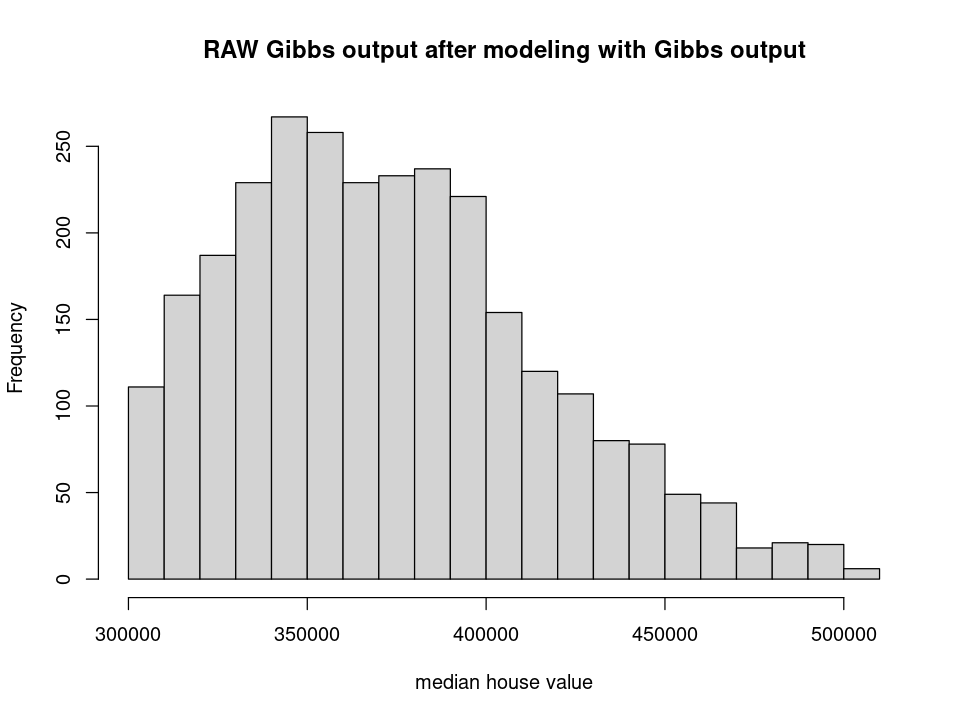

In [334]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, main="RAW Gibbs output after modeling with Gibbs output",
     xlab="median house value")


### Compute the RSS gain

In [335]:
names(z_preds) <- rownames(dat[censored,])
print(head(z_preds))


1      2      3      4      5    104 
446057 424446 470672 492527 364694 322218

In [336]:
# Compute the RSS gain.

gibbs05_rss <- round(sum((actual_vals[rows_censored] - z_preds[rows_censored])^2))
(gibbs05_RSSgain <- round(1 - gibbs05_rss/cap_rss, 4))
# 0.4304

# When the capped values were used in the intial model (m01), this
# score was 50.8%.  We are clearly worse off in terms of RSS gain
# when we start with a model which is tuned using imputed values
# from a Gibbs sampler.


[1] 0.4304

# Section 7: Does the RSS improve if we move the cap slightly closer to the predicted mean?

In [33]:
censored_rows <- rownames(dat_noCap[which(dat_noCap$median_house_value >= 300000),])
length(censored_rows)

# Set cap to 320K.
dat_wCap <- dat_noCap
dat_wCap[censored_rows,]$median_house_value <- 320000


[1] 2833

In [34]:
dat <- dat_wCap


In [145]:
# Fit a new model.

lm06 <- lm(I(median_house_value^0.51) ~ 
          
           I(median_income^0.937) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat) 

lm06.summary <- summary(lm06)
lm06.summary[[1]] <- ""; round(lm06.summary$adj.r.squared, 3)


[1] 0.703

In [146]:
ncvTest(lm06)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.22229, Df = 1, p = 0.637

In [147]:
residualPlots(lm06, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.937)        -12.92          < 2e-16
I(long_transf^-0.5)             2.05          0.04018
I(long_transf^-1)              11.73          < 2e-16
I(long_transf^-1.5)            12.12          < 2e-16
latitude                        1.59          0.11092
I(latitude^2)                   0.36          0.71655
I(latitude^3)                  33.36          < 2e-16
I(latitude^4)                  33.34          < 2e-16
pop_per_hh                     -0.63          0.52812
I(pop_per_hh^2)                -8.27          < 2e-16
I(housing_median_age^0.15)     -3.52          0.00043
HHdens_ln                       8.91          < 2e-16
Tukey test                      0.10          0.91873


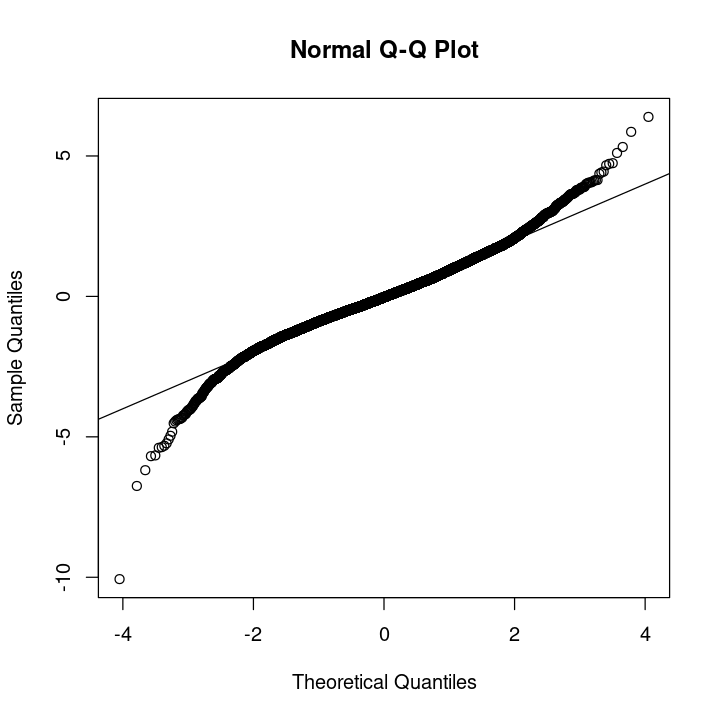

In [148]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(lm06, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


### Re-run Gibbs sampler

In [149]:
cap <- 300000
response_var_power <- 0.51
inv_pwr <- 1/response_var_power

C <- cap^response_var_power
C_upper <- (1.68*cap)^response_var_power

censored <- (dat$median_house_value)^response_var_power >= C

# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$median_house_value)^response_var_power)
z[censored] <- runif(n.censored, C, C_upper)


In [150]:
length(censored)
n.censored


[1] 19574

[1] 2833

In [151]:
summary(z[censored])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    622     668     716     716     764     809 

In [152]:
# Identify the rows that are censored.

rows_censored <- rownames(dat)[censored]
c(head(rows_censored), tail(rows_censored))
length(rows_censored)


[1] "1"     "2"     "3"     "4"     "5"     "104"   "20502" "20503" "20504"
[10] "20505" "20528" "20534"

[1] 2833

In [153]:
# Create matrix X for the terms in our model.

X <- dat

X$median_income <- (X$median_income)^0.937

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$long_1 <- (X$long_transf)^-0.5
X$long_2 <- (X$long_transf)^-1
X$long_3 <- (X$long_transf)^-1.5

X$pphh1 <-  X$pop_per_hh
X$pphh2 <- (X$pop_per_hh)^2

X$housing_median_age <- (X$housing_median_age)^0.15

X$HHdens_by_long <- X$HHdens_ln * X$long_transf
X$HHdens_by_income <- X$HHdens_ln * X$median_income
X$HHdens_3way <- X$HHdens_ln * X$median_income * X$housing_median_age



X <- X[, c("median_income","long_1","long_2","long_3","latitude","lat2",
           "lat3","lat4","pphh1","pphh2", "housing_median_age",
           "HHdens_ln", "HHdens_by_long","HHdens_by_income",
           "HHdens_3way")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 19574    16

[1] "intercept"          "median_income"      "long_1"            
 [4] "long_2"             "long_3"             "latitude"          
 [7] "lat2"               "lat3"               "lat4"              
[10] "pphh1"              "pphh2"              "housing_median_age"
[13] "HHdens_ln"          "HHdens_by_long"     "HHdens_by_income"  
[16] "HHdens_3way"

In [154]:
# Fit a regression using the crude starting values of z.

lm02_tst <- lm(z ~ 
             
           I(median_income^0.937) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
              
           data= dat)    

# Obtain a sample draw of the model coefficients and of
# parameter sigma.
sim.1 <- sim(lm02_tst, n.sims=1)


In [155]:
beta <- coef(sim.1)
dim(beta)
colnames(beta)


[1]  1 16

[1] "(Intercept)"                               
 [2] "I(median_income^0.937)"                    
 [3] "I(long_transf^-0.5)"                       
 [4] "I(long_transf^-1)"                         
 [5] "I(long_transf^-1.5)"                       
 [6] "latitude"                                  
 [7] "I(latitude^2)"                             
 [8] "I(latitude^3)"                             
 [9] "I(latitude^4)"                             
[10] "pop_per_hh"                                
[11] "I(pop_per_hh^2)"                           
[12] "I(housing_median_age^0.15)"                
[13] "HHdens_ln"                                 
[14] "HHdens_ln:long_transf"                     
[15] "HHdens_ln:median_income"                   
[16] "HHdens_ln:median_income:housing_median_age"

In [156]:
# Here are means for 6 different normal distributions.

means <- as.matrix(X) %*% t(beta)
length(means)
round(head(as.vector(means)^inv_pwr))


[1] 19574

[1] 373732 393850 289356 243000 201325 208543

In [157]:
# All values should be between 300K and 504K
z.old <- z[censored]
round(head(z.old)^inv_pwr)


[1] 497934 362979 410240 457725 430676 490476

In [160]:
# All values should be between 300K and 504K.
sigma <- sigma.hat(sim.1)
round(sigma, 4)

z.new <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
round(head(as.vector(z.new)^inv_pwr))


[1] 76.464

[1] 421925 408731 306315 314575 367304 366708

In [161]:
summary(z.new^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300061  324553  354940  364894  396595  503831 

In [162]:
# For the Gibbs sampler, the above is now put into
# a loop.  We first test with 100 iterations.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

# We have 16 terms in the model (including the intercept) as
# well as parameter sigma.  Thus, besides storing the imputed
# values, we need to have 17 additional slots.
sims <- array(NA, c(n.iter, n.chains, 17 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        m01.1 <- lm(z ~ 
                    
           I(median_income^0.937) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)   
        
        sim.1 <- sim(m01.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        stopifnot(sum(z[censored] < Inf) == n.censored)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.77 minutes.


Time difference of 4.77 mins

In [ ]:
# Check for convergence.

# sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
# print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [163]:
save(sims, file="/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims_raw06_hhvals_300Kcap.RData")


In [281]:
load("/home/greg/Documents/stat/sandbox/Pfizer/datasets/housing/sims_raw06_hhvals_300Kcap.RData")


In [164]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 2850

In [165]:
sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [166]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 704.76 714.59 675.14 674.54 674.52 675.84

[1] 46.77 48.17 39.76 38.82 39.14 39.51

In [167]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    673     674     675     679     676     790 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   17.4    39.2    39.6    40.5    40.3    48.4 

In [168]:
summary(round(z_means^inv_pwr))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 350756  352337  352883  357336  354170  480712 

In [169]:
# Average estimate of the sd.

(sd_estimate <- round((679 + 40.5)^inv_pwr) - round(679^inv_pwr))
# $42,950

# This estimate is almost 6K higher than what we saw when the cap
# was at 300K.


[1] 42950

In [170]:
# Here is a fuller summary for the stddevs.

ans <- round((z_means + z_sds)^inv_pwr) - round(z_means^inv_pwr)
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  21016   41275   41688   42939   42560   54530 

In [171]:
# Get some predictions, using rnorm.trunc03.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)

# Notice that the mean is at 364.8K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300024  335872  360082  364835  387976  503211 

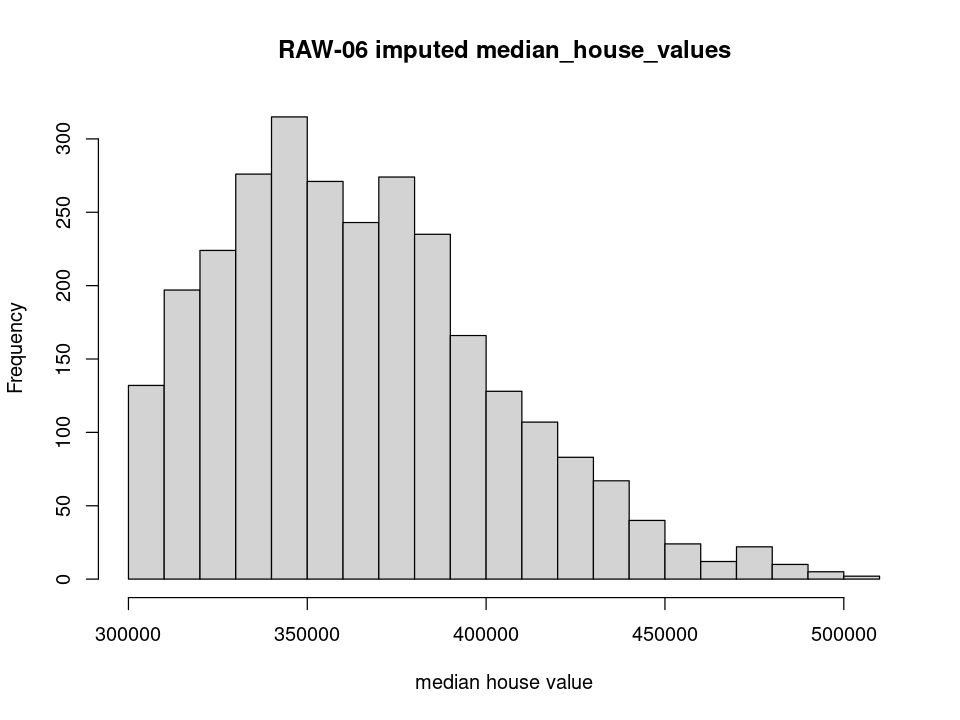

In [172]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, main="RAW-06 imputed median_house_values",
     xlab="median house value")


### Compute the RSS gain

In [173]:
names(z_preds) <- rownames(dat[censored,])
print(head(z_preds))


     1      2      3      4      5    104 
435525 420302 448081 471080 355766 320331 


In [175]:
# Compute the RSS gain.

cap_rss <- round(sum((actual_vals[rows_censored] - 300000)^2))

gibbs06_rss <- round(sum((actual_vals[rows_censored] - z_preds[rows_censored])^2))
(gibbs06_RSSgain <- round(1 - gibbs06_rss/cap_rss, 4))
# 0.4895

# When the capped values were used in the intial model (m01), this
# score was 50.8%.


[1] 0.4895

# Final Comments for Appendix C

The above tests in Sections 4-7 suggest that we will not be able to improve the Gibbs sampler output by altering the values of the censored data used to construct the model that the Gibbs sampler relies upon.  It appears that we will get the best output from the Gibbs sampler, as measured by RSS gain, if we model with the capped values in place.

If we have a good prediction for the mean of the actual, unobserved values (the data for which we need the imputed values), we can improve upon the Gibbs sampler output by shifting it over until the mean of the output is equal to our prediction for the mean.  This can be done, within limits, without adversely affecting the RSS gain we see from the original Gibbs output.

At present, I do not know of any way to improve upon the shape of the Gibbs output when the distribution of the imputed values is not at all near what we expect to see.  More precisely, I do not currently have a way to improve upon the shape of the Gibbs output without degrading the RSS score of the imputed values.